In [1]:
import uproot3 as uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
def validate_corrections(run, df, Ndf):

    fig = plt.figure(figsize=(8,5),dpi=100)

    mi,ma = -10.,10.
    b = 0.5
    n = int((ma-mi)/b)
    plt.hist(df["mean_residual_ns"], bins=n, range=(mi,ma), lw=2, histtype="step",
         label="Base sample\nMean: {:.2f}ns\nStd: {:.2f}".format(
             np.mean(df["mean_residual_ns"].to_numpy()),np.std(df["mean_residual_ns"].to_numpy())))
    plt.hist(Ndf["mean_residual_ns"], bins=n, range=(mi,ma), lw=2, histtype="step",
         label="Correction w/ delays\nMean: {:.2f}ns\nStd: {:.2f}".format(
             np.mean(Ndf["mean_residual_ns"].to_numpy()),np.std(Ndf["mean_residual_ns"].to_numpy())))

    plt.grid()
    plt.title("Run {} (including HW + laser)".format(run))
    plt.xlabel("Cosmics residuals")
    plt.ylabel("# PMTs")
    plt.legend()
    plt.show()

In [3]:
def compare_changes(df, Ndf, board):
    
    channels = df.join( Ndf[["entries", "mean_residual_ns"]], on=["channel_id"], rsuffix="_new", how='inner')
    channels["diff"] = channels["mean_residual_ns"]-channels["mean_residual_ns_new"]
    
    bch = getChannelsFromBoard(board)
    _sel = channels.channel_id.isin(bch)

    fig, ax = plt.subplots(1,2,figsize=(16,5),dpi=100)

    ax[0].scatter( channels["channel_id"], channels["mean_residual_ns"], label="Base sample")
    ax[0].scatter( channels["channel_id"], channels["mean_residual_ns_new"], label="Change to {}".format(board))

    ax[0].axvline(x=90,color='red',linestyle="dotted")
    ax[0].axvline(x=180,color='red',linestyle="dotted")
    ax[0].axvline(x=270,color='red',linestyle="dotted")

    ax[0].set_xlabel("Channel ID")
    ax[0].set_ylabel("Residuals [ns]")
    ax[0].grid()
    ax[0].legend()

    ax[1].scatter( channels["channel_id"], channels["diff"])
    ax[1].scatter( channels[_sel]["channel_id"], channels[_sel]["diff"], marker="x", label=board)

    ax[1].axvline(x=90,color='red',linestyle="dotted")
    ax[1].axvline(x=180,color='red',linestyle="dotted")
    ax[1].axvline(x=270,color='red',linestyle="dotted")

    ax[1].set_xlabel("Channel ID")
    ax[1].set_ylabel("Difference (OLD-NEW) [ns]")
    ax[1].grid()
    ax[1].legend()
    plt.show()

In [4]:
def compare_changes_cryowise(run, df, Ndf):
    fig, ax = plt.subplots(1, 2,figsize=(16,5),dpi=100)

    mi,ma = -10.,10.
    b = 0.5
    n = int((ma-mi)/b)
    _selE = df.channel_id<180
    _selE1 = Ndf.channel_id<180
    _selW = df.channel_id>=180
    _selW1 = Ndf.channel_id>=180

    ax[0].hist(df[_selE]["mean_residual_ns"], bins=n, range=(mi,ma), lw=2, histtype="step",
         label="Base sample \nMean: {:.2f}ns\nStd: {:.2f}".format(
             np.mean(df[_selE]["mean_residual_ns"].to_numpy()),np.std(df[_selE]["mean_residual_ns"].to_numpy())))
    ax[0].hist(Ndf[_selE1]["mean_residual_ns"], bins=n, range=(mi,ma), lw=2, histtype="step",
         label="After additional delays\nMean: {:.2f}ns\nStd: {:.2f}".format(
             np.mean(Ndf[_selE1]["mean_residual_ns"].to_numpy()),np.std(Ndf[_selE1]["mean_residual_ns"].to_numpy())))
    ax[0].grid()
    ax[0].set_title("Run {} (including HW + laser) - EAST ONLY".format(run))
    ax[0].set_xlabel("Cosmics residuals")
    ax[0].set_ylabel("# PMTs")
    ax[0].legend()

    ax[1].hist(df[_selW]["mean_residual_ns"], bins=n, range=(mi,ma), lw=2, histtype="step",
         label="Base sample\nMean: {:.2f}ns\nStd: {:.2f}".format(
             np.mean(df[_selW]["mean_residual_ns"].to_numpy()),np.std(df[_selW]["mean_residual_ns"].to_numpy())))
    ax[1].hist(Ndf[_selW1]["mean_residual_ns"], bins=n, range=(mi,ma), lw=2, histtype="step",
         label="After additional delays\nMean: {:.2f}ns\nStd: {:.2f}".format(
             np.mean(Ndf[_selW1]["mean_residual_ns"].to_numpy()),np.std(Ndf[_selW1]["mean_residual_ns"].to_numpy())))
    ax[1].grid()
    ax[1].set_title("Run {} (including HW + laser) - WEST ONLY".format(run))
    ax[1].set_xlabel("Cosmics residuals")
    ax[1].set_ylabel("# PMTs")
    ax[1].legend()

    plt.show()

In [29]:
# The fit function
def gaus(x,a,mean,sigma):
    return a*np.exp(-(x-mean)**2/(2*sigma**2))

# The fit strategy
def fitGaussian(hdf, target='mean_residual_ns', BINSIZE=0.5,RMIN=-10.0,RMAX=10., p0=(0.1, 1.)):

    nbins=int((RMAX-RMIN)/BINSIZE)
    ys,edges = np.histogram(hdf[target],bins=nbins,range=(RMIN,RMAX))
    xs=np.array([edges[i]+0.5*(edges[i+1]-edges[i]) for i in range(len(ys))])

    param = [np.max(ys), p0[0], p0[1] ]
    bounds = np.array([(param[0]*0.5,param[0]*1.5),
              (param[1]*0.2,param[1]*1.3),
              (param[2]*0.1,param[2]*1.4)])
    
    param,pcov = curve_fit(gaus, xs, ys, p0=param, bounds=(bounds[:,0],bounds[:,1]) )
    param_errors = np.diag(pcov)**0.5
    
    return xs, ys, param, param_errors

def plot_fit(run, df, Ndf):

    fig = plt.figure(figsize=(8,5),dpi=200)

    mi=-5.
    ma=5.
    b=0.3
    n= int((ma-mi)/b)
    
    xs1, ys1, param1, param_errors1 = fitGaussian(df,BINSIZE=b,RMIN=mi,RMAX=ma)
    xs2, ys2, param2, param_errors2 = fitGaussian(Ndf,BINSIZE=b,RMIN=mi,RMAX=ma)
    xss = np.arange(mi,ma,0.1)
    
    plt.hist(df["mean_residual_ns"], bins=n, range=(mi,ma), lw=2, histtype="step",
         label="Laser only\nMean: {:.2f}ns\nStd: {:.2f}".format(
             np.mean(df["mean_residual_ns"].to_numpy()),np.std(df["mean_residual_ns"].to_numpy())))
    plt.plot(xss,gaus(xss,*param1),"-.",color="darkblue",lw=3,
             label="$\mu$: {:.2f} ns\n$\sigma$: {:.2f} ns".format(param1[1],param1[2]))
    
    plt.hist(Ndf["mean_residual_ns"], bins=n, range=(mi,ma), lw=2, histtype="step",
         label="Laser + Cosmics\nMean: {:.2f}ns\nStd: {:.2f}".format(
             np.mean(Ndf["mean_residual_ns"].to_numpy()),np.std(Ndf["mean_residual_ns"].to_numpy())))
    plt.plot(xss,gaus(xss,*param2),"-.",color="red",lw=3,
        label="$\mu$: {:.2f} ns\n$\sigma$: {:.2f} ns".format(param2[1],param2[2]))

    plt.grid()
    plt.title("Run {} (including HW + laser + cosmics)".format(run))
    plt.xlabel("Cosmics residuals [ns]")
    plt.ylabel("# PMTs")
    order = [2,0,3,1]
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 
    
    plt.savefig("../figs/run{}_laseronly_vs_lasercosmics.pdf".format(run))
    plt.show()

In [30]:
import sqlite3
def readSqlitedb(database="/cvmfs/icarus.opensciencegrid.org/products/icarus/icarus_data/v09_79_01/icarus_data/database/ChannelMapICARUS_20230829.db", table="pmt_placements"):

    # Read sqlite query results into a pandas DataFrame
    con = sqlite3.connect(database)
    df = pd.read_sql_query("SELECT * from {}".format(table), con)
    con.close()
    return df

def getBoards():
    geo = readSqlitedb()
    boards = geo.digitizer_label.to_numpy()
    return np.unique(boards)

def getChannelsFromBoard(board):
    geo = readSqlitedb()
    channels = geo[geo.digitizer_label==board].channel_id.to_numpy()
    return channels

def getBoardFromChannel(channel):
    geo = readSqlitedb()
    board = geo[geo.channel_id==channel].digitizer_label.values[0]
    return board

def getChannelFromPMTid(pmt):
    geo = readSqlitedb()
    channel = geo[geo.pmt_id==pmt].channel_id.values[0]
    return channel

In [31]:
def show_status_channels(run, df):
    boards = getBoards()

    fig = plt.figure(figsize=(8,5),dpi=100)
    for b in boards:
    
        c = getChannelsFromBoard(b)
        _sel = df.channel_id.isin(c)

        plt.scatter( df[_sel]["channel_id"], df[_sel]["mean_residual_ns"], label=b)

    plt.axvline(x=90,color='red',linestyle="dotted")
    plt.axvline(x=180,color='red',linestyle="dotted")
    plt.axvline(x=270,color='red',linestyle="dotted")

    plt.title("Run {}".format(run))
    plt.xlabel("Channel ID")
    plt.ylabel("Residuals [ns]")
    plt.grid()
    plt.legend(bbox_to_anchor=(1.0, 1.1))
    plt.show()
    
def show_status_boards(df):
    fig = plt.figure(figsize=(8,5),dpi=100)

    canali = df.channel_id.to_numpy()
    residui = df.mean_residual_ns.to_numpy()
    schede = []
    for i, can in enumerate(canali):

        schede.append(getBoardFromChannel(can))
    
    plt.scatter( schede, residui )
    
    #plt.xlabel("Digitizer board")
    plt.ylabel("Residuals [ns]")
    plt.grid()
    plt.setp(plt.gca().get_xticklabels(), rotation=60, ha="right")

    plt.axvspan(xmin="EE-BOT-C", xmax="EE-TOP-A", color="green", alpha=0.1, label="EE")
    plt.axvspan(xmin="EE-TOP-A", xmax="EW-TOP-A", color="red", alpha=0.1, label="EW")
    plt.axvspan(xmin="EW-TOP-A", xmax="WE-TOP-A", color="orange", alpha=0.1, label="WE")
    plt.axvspan(xmin="WE-TOP-A", xmax="WW-TOP-A", color="blue", alpha=0.1, label="WW")

    plt.legend()
    plt.show()

In [32]:
def show_status_walls(df):
    
    fig, ax = plt.subplots(4,figsize=(14,7),dpi=100)
    names = [ "EE", "EW", "WE", "WW"]

    _selEE = (df.channel_id<90)
    _selEW = (df.channel_id<180)
    _selWE = (df.channel_id<270)
    _selWW = (df.channel_id<360)

    mini = np.min(df.mean_residual_ns.to_numpy())
    maxi = np.max(df.mean_residual_ns.to_numpy())

    out = ax[0].scatter(df[_selEE].z, df[_selEE].y, c=df[_selEE].mean_residual_ns, cmap='coolwarm')
    out = ax[1].scatter(df[_selEW].z, df[_selEW].y, c=df[_selEW].mean_residual_ns, cmap='coolwarm')   
    out = ax[2].scatter(df[_selWE].z, df[_selWE].y, c=df[_selWE].mean_residual_ns, cmap='coolwarm') 
    out = ax[3].scatter(df[_selWW].z, df[_selWW].y, c=df[_selWW].mean_residual_ns, cmap='coolwarm')

    fig.subplots_adjust(right=0.8, hspace=0.9)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    plt.colorbar(out, cax=cbar_ax, label="Residuals [ns]", orientation='vertical', pad=0.01 )

    for i in range(0,4): 
        ax[i].set_title(names[i])
        ax[i].set_xlabel("Z [cm]",fontsize=12)
        ax[i].set_ylabel("Y [cm]", fontsize=12) 

    plt.show()

In [33]:
def check_stats(run, path="residuals_test2"):
    t = "../output/residuals/Run_2/run{}_{}.csv".format(run,path)
    dt = pd.read_csv(t)
    
    boards = getBoards()

    fig = plt.figure(figsize=(8,5),dpi=100)
    for b in boards:
    
        c = getChannelsFromBoard(b)
        _sel = dt.channel_id.isin(c)

        plt.scatter( dt[_sel]["channel_id"], dt[_sel]["entries"], label=b)
        
    plt.axvline(x=90,color='red',linestyle="dotted")
    plt.axvline(x=180,color='red',linestyle="dotted")
    plt.axvline(x=270,color='red',linestyle="dotted")
    #plt.legend()
    plt.grid()
    plt.show()
    
    fig2 = plt.figure(figsize=(8,5),dpi=100)
    for b in boards:
    
        c = getChannelsFromBoard(b)
        _sel = dt.channel_id.isin(c)

        plt.scatter( dt[_sel]["entries"], dt[_sel]["mean_residual_ns"], label=b)
        
    plt.axvline(x=90,color='red',linestyle="dotted")
    plt.axvline(x=180,color='red',linestyle="dotted")
    plt.axvline(x=270,color='red',linestyle="dotted")
    #plt.legend()
    plt.grid()
    plt.show()

## Periodo 1 - Run 9337

In [10]:
res_9337 = "../output/residuals/Run_2/run9337_residuals_test8ns.csv"
res_9441 = "../output/residuals/Run_2/run9441_residuals_test8ns.csv"
res_9595 = "../output/residuals/Run_2/run9595_residuals_test8ns.csv"

N1res_9337 = "../output/residuals/Run_2/run9337_residuals_test8ns_fixEast_step1.csv"
N2res_9337 = "../output/residuals/Run_2/run9337_residuals_test8ns_fixEast_step2.csv"
N3res_9337 = "../output/residuals/Run_2/run9337_residuals_test8ns_fixEast_step3.csv"

In [11]:
df9337 = pd.read_csv(res_9337)
df9595 = pd.read_csv(res_9595)
df9441 = pd.read_csv(res_9441)

N1df9337 = pd.read_csv(N1res_9337)
N2df9337 = pd.read_csv(N2res_9337)
N3df9337 = pd.read_csv(N3res_9337)

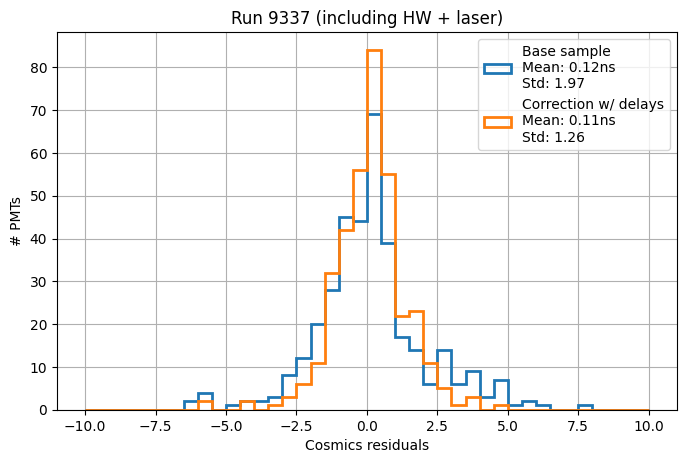

In [12]:
validate_corrections(9337,df9337,N1df9337)
validate_corrections(9337,df9337,N2df9337)
validate_corrections(9337,df9337,N3df9337)

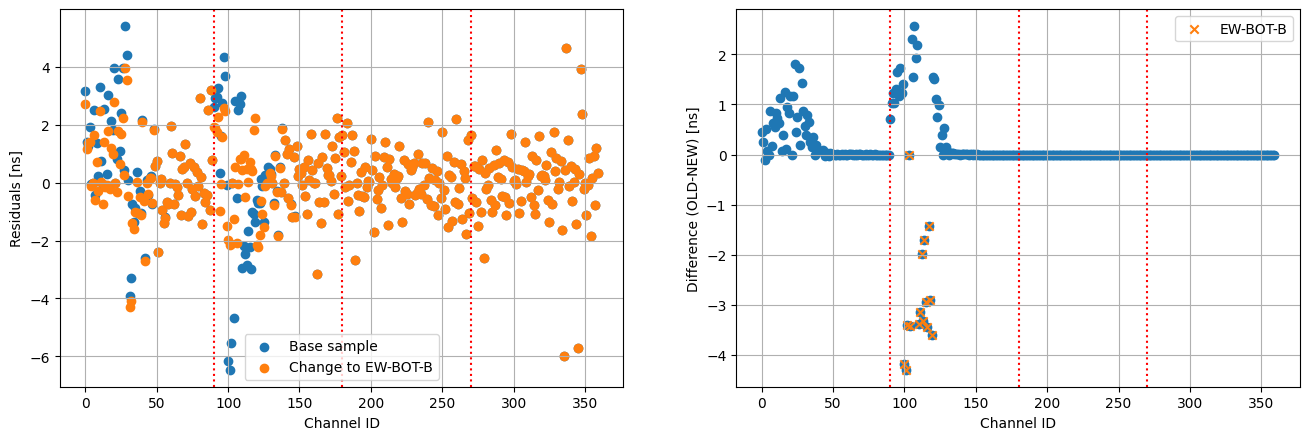

In [13]:
compare_changes(df9337,N1df9337,"EE-TOP-B")
compare_changes(N1df9337,N2df9337,"EE-TOP-C")
compare_changes(N2df9337,N3df9337,"EW-BOT-B")

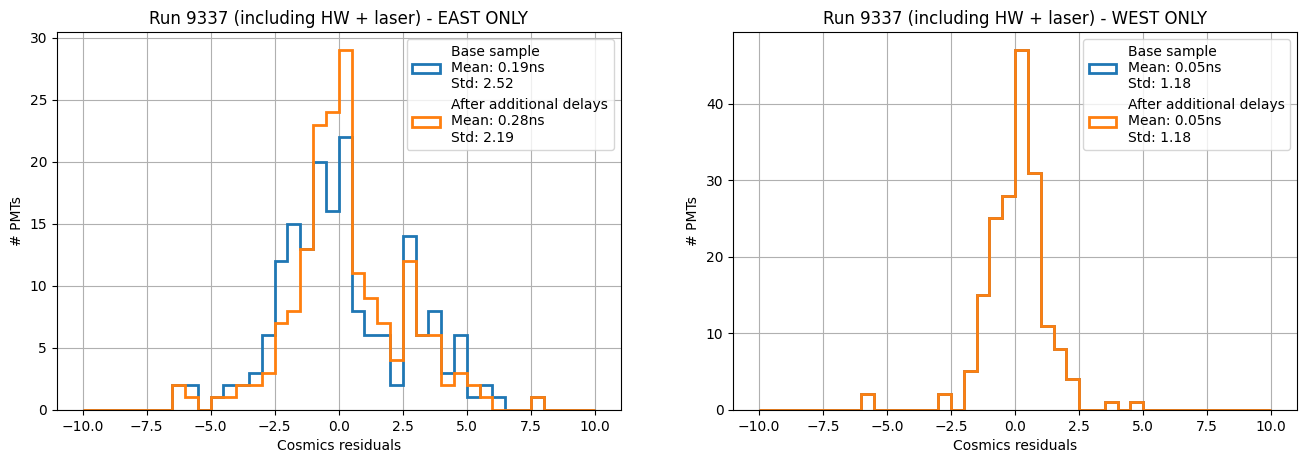

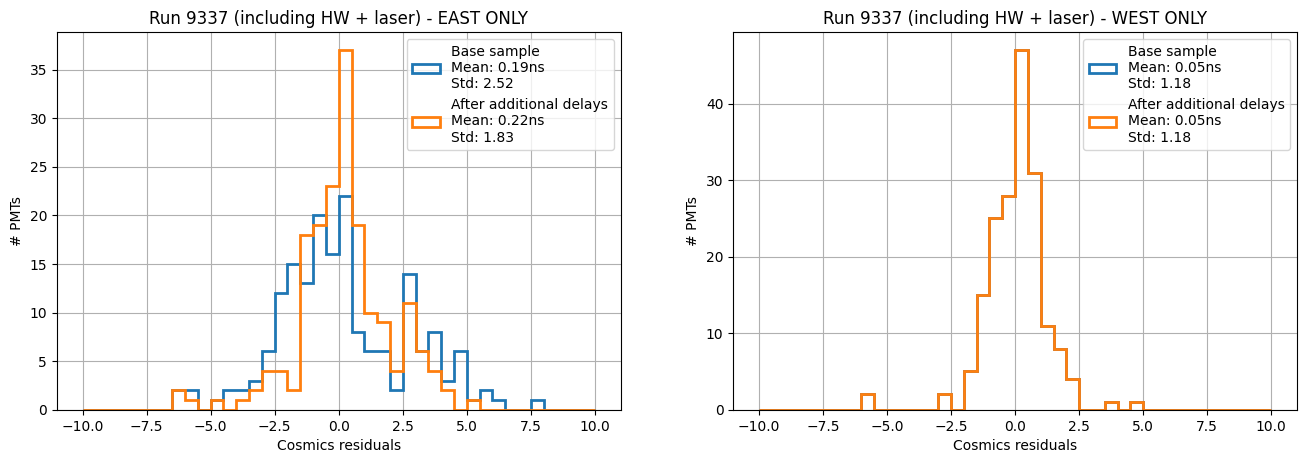

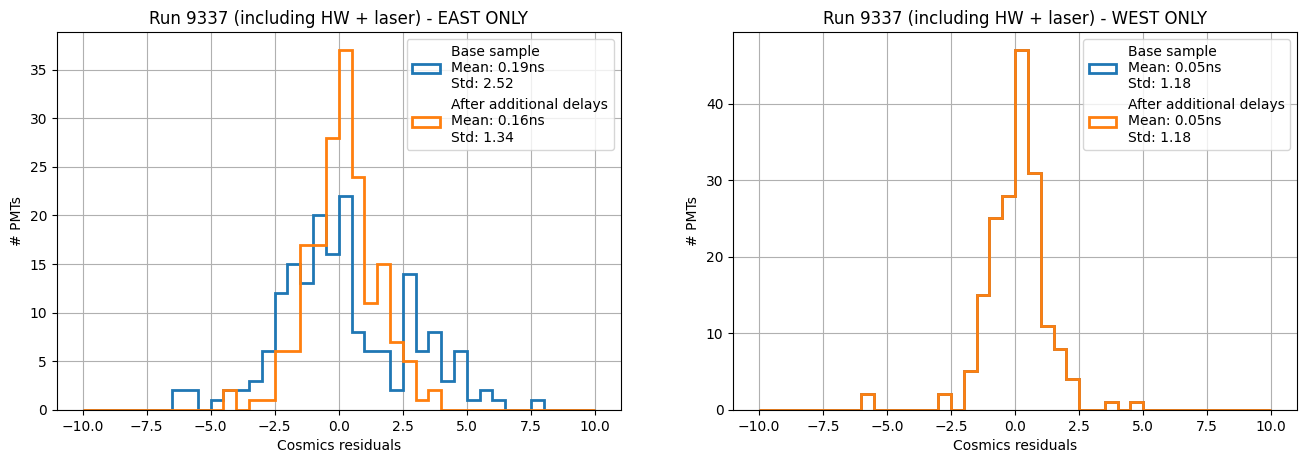

In [14]:
compare_changes_cryowise(9337,df9337,N1df9337)
compare_changes_cryowise(9337,df9337,N2df9337)
compare_changes_cryowise(9337,df9337,N3df9337)

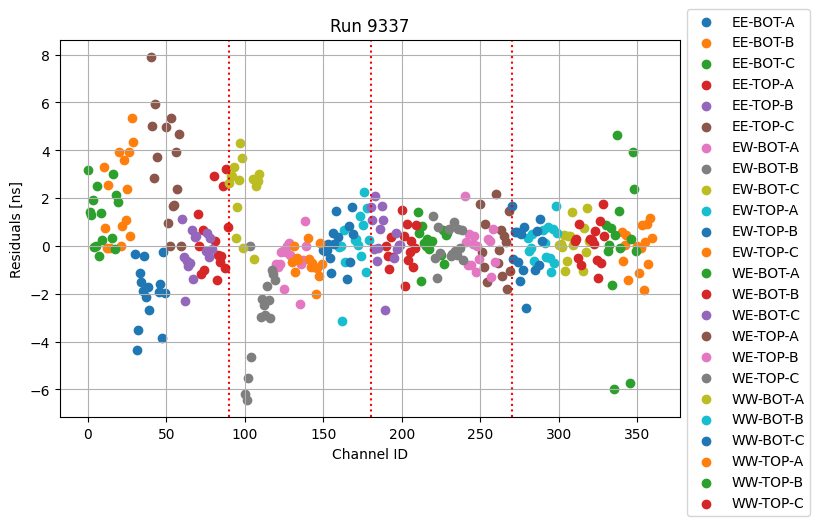

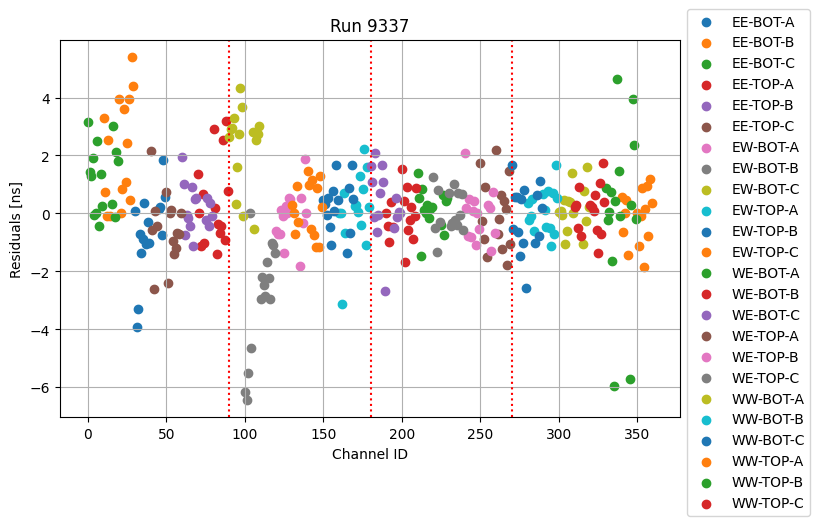

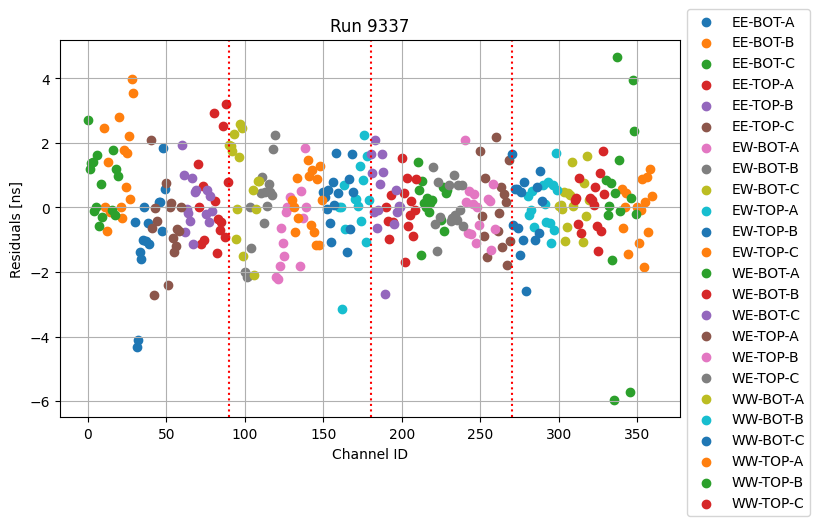

In [15]:
show_status_channels(9337,df9337)
show_status_channels(9337,N1df9337)
show_status_channels(9337,N2df9337)
show_status_channels(9337,N3df9337)

### Alternatives

In [16]:
print( getChannelsFromBoard("EW-BOT-C") )
print( getChannelsFromBoard("EE-BOT-B") )
print( getChannelsFromBoard("EE-BOT-C") )

[108 106 107 105 109  90  91  92  93  94  98  96  97  95  99]
[28 29 25 26 27 20 23 24 22 21 10 13 14 12 11]
[18 19 15 16 17  8  9  5  6  7  0  3  4  2  1]


In [17]:
alt = "../output/residuals/Run_2/run9337_residuals_test8ns_fixEast_alternative.csv"
alt1 = "../output/residuals/Run_2/run9441_residuals_test8ns_fixEast_alternative.csv"
alt2 = "../output/residuals/Run_2/run9595_residuals_test8ns_fixEast_alternative.csv"
dfalt = pd.read_csv(alt)
dfalt1 = pd.read_csv(alt1)
dfalt2 = pd.read_csv(alt2)

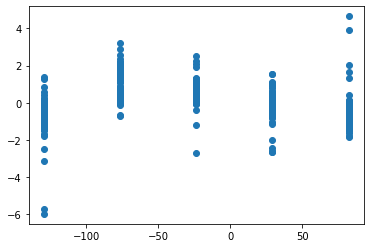

In [18]:
plt.scatter(dfalt.y,dfalt.mean_residual_ns)

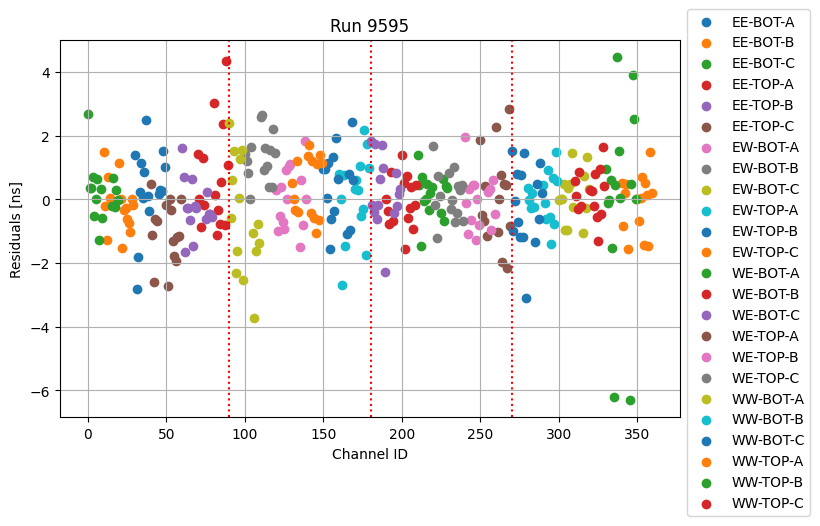

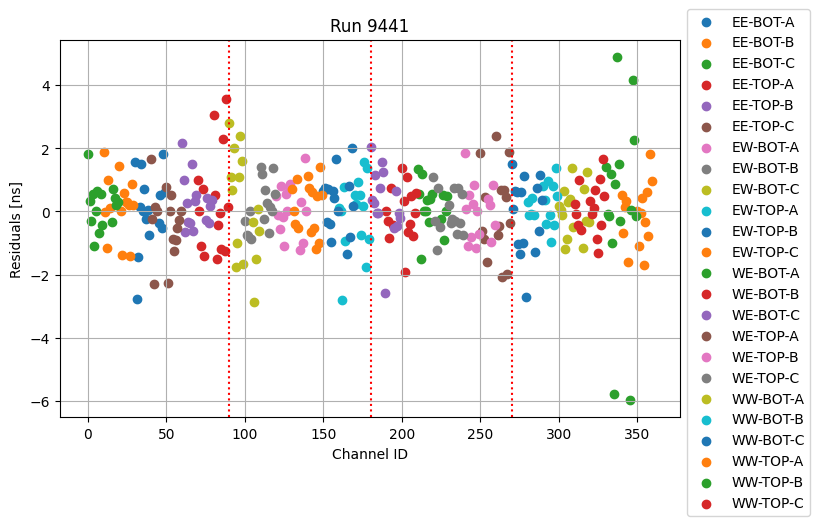

In [19]:
show_status_channels(9337,dfalt)
show_status_channels(9595,dfalt1)
show_status_channels(9441,dfalt2)

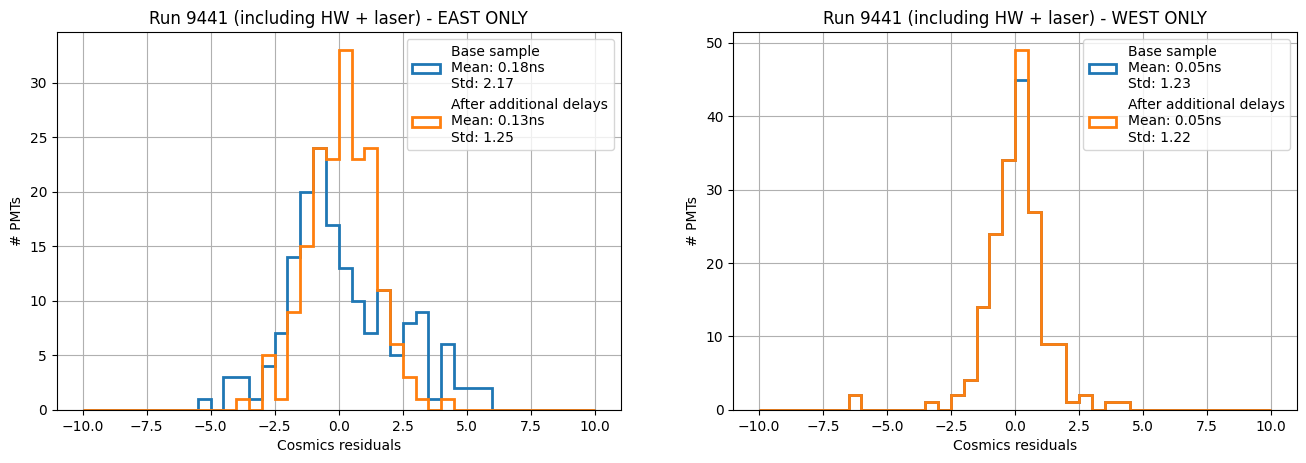

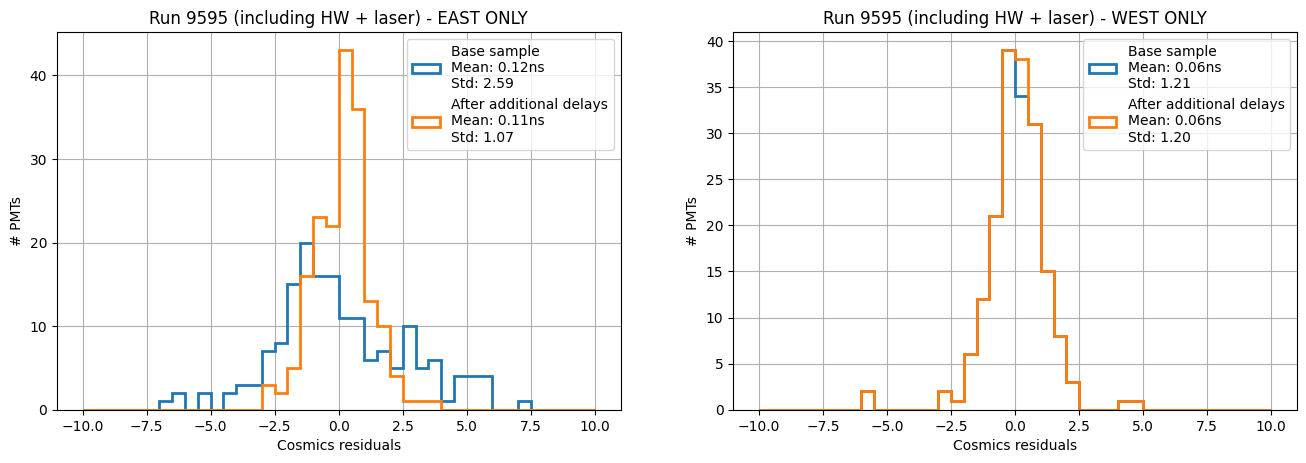

In [20]:
compare_changes_cryowise(9337,df9337,dfalt)
compare_changes_cryowise(9441,df9441,dfalt1)
compare_changes_cryowise(9595,df9595,dfalt2)

# Validation samples

In [34]:
res = "../output/residuals/Run_2/run9595_residuals_test8ns.csv"
res_corr = "../output/residuals/Run_2/run9595_residuals_test8ns_CORRw9337.csv"
Nres = "../output/residuals/Run_2/run9595_residuals_test8ns_fixEast.csv"
Nres_corr = "../output/residuals/Run_2/run9595_residuals_test8ns_fixEast_CORRw9337.csv"
Nres_alt = "../output/residuals/Run_2/run9595_residuals_test8ns_fixEast_alternative.csv"
Nres_alt_corr = "../output/residuals/Run_2/run9595_residuals_test8ns_fixEast_alternative_CORRw9337.csv"

In [35]:
df = pd.read_csv(res)
df_corr = pd.read_csv(res_corr)
Ndf = pd.read_csv(Nres)
Ndf_corr = pd.read_csv(Nres_corr)
Ndf_alt = pd.read_csv(Nres_alt)
Ndf_alt_corr = pd.read_csv(Nres_alt_corr)

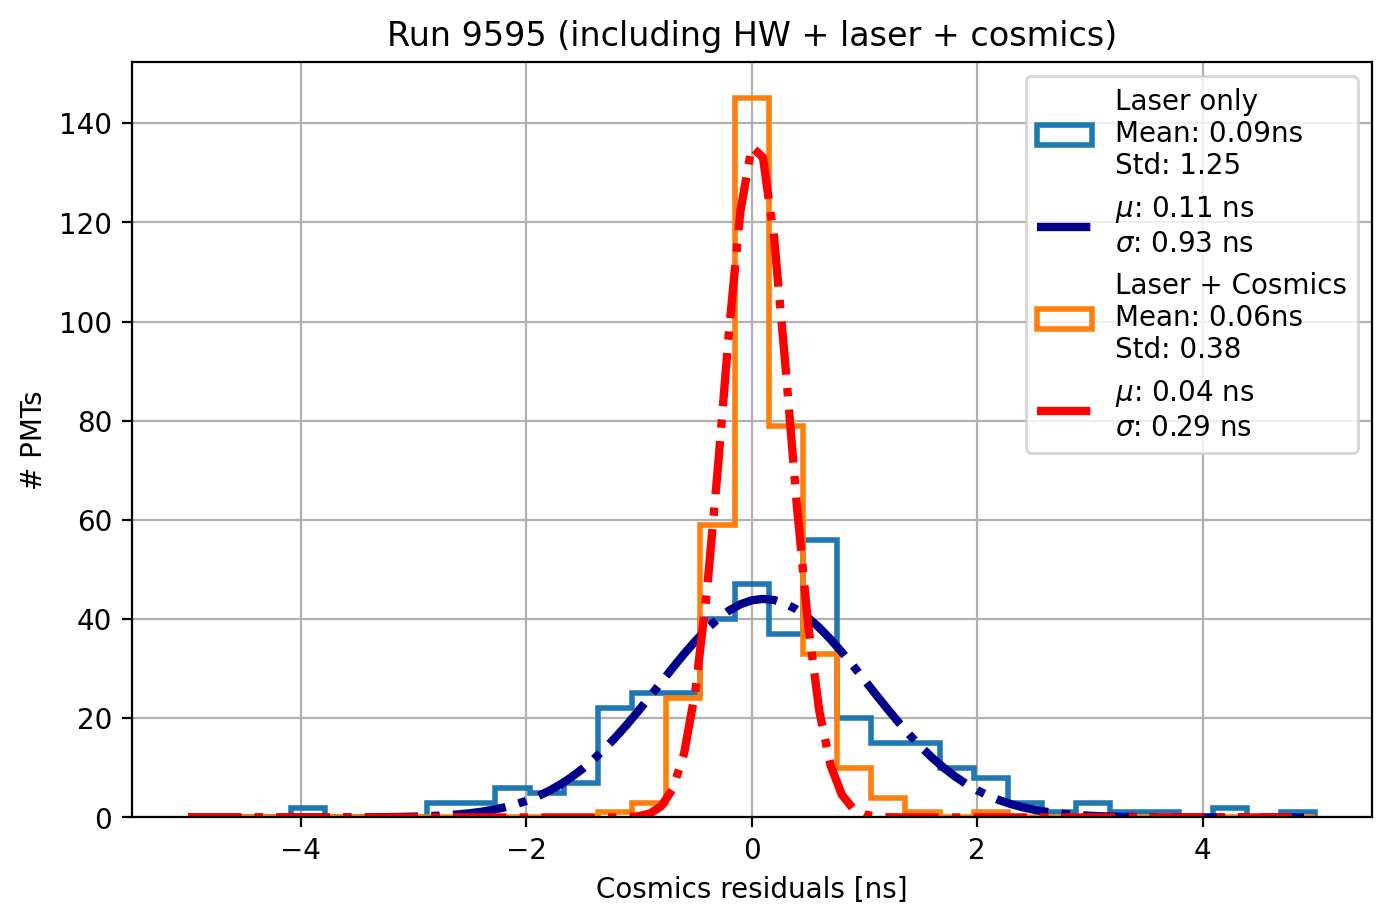

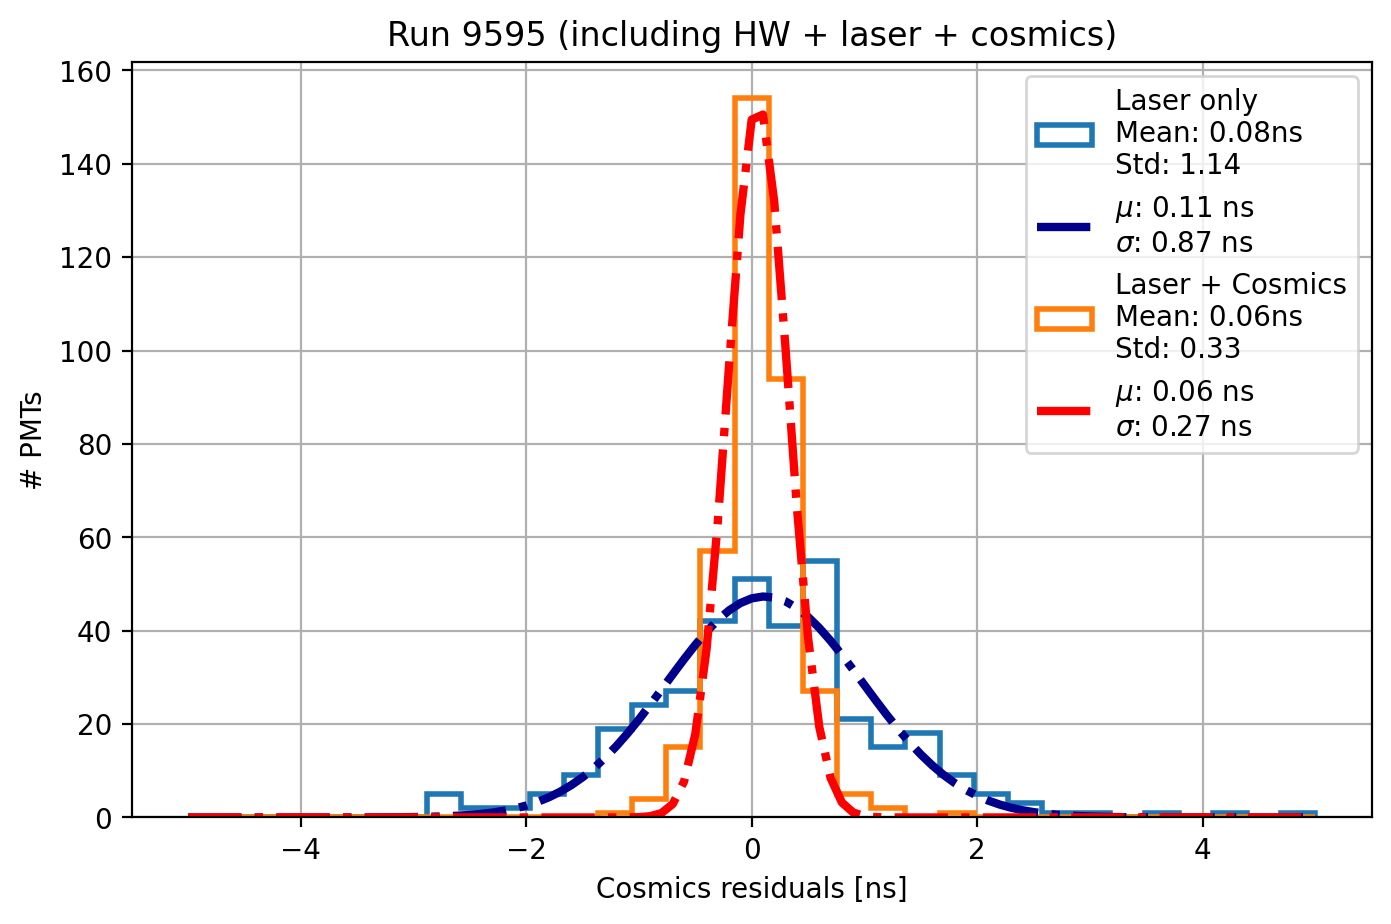

In [36]:
plot_fit(9595,df,df_corr)
plot_fit(9595,Ndf,Ndf_corr)
plot_fit(9595,Ndf_alt,Ndf_alt_corr)

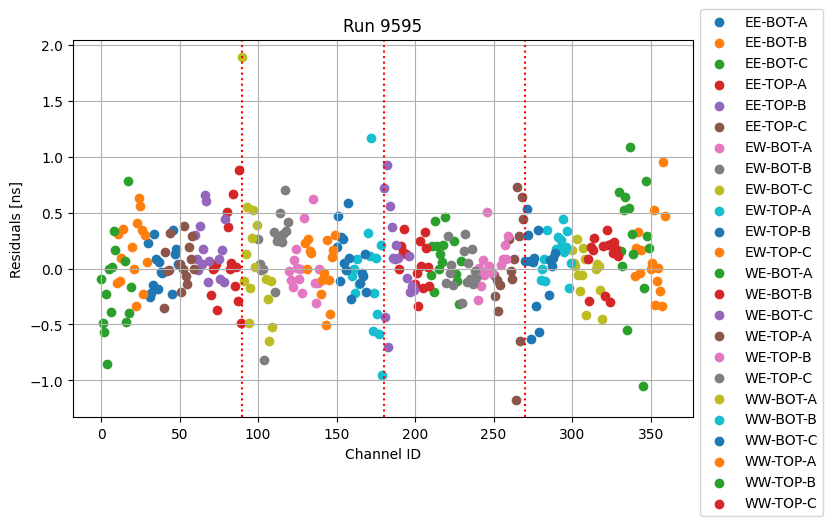

In [24]:
show_status_channels(9595,Ndf_alt_corr)

In [25]:
res = "../output/residuals/Run_2/run9441_residuals_test8ns.csv"
res_corr = "../output/residuals/Run_2/run9441_residuals_test8ns_CORRw9337.csv"
Nres = "../output/residuals/Run_2/run9441_residuals_test8ns_fixEast.csv"
Nres_corr = "../output/residuals/Run_2/run9441_residuals_test8ns_fixEast_CORRw9337.csv"
Nres_alt = "../output/residuals/Run_2/run9441_residuals_test8ns_fixEast_alternative.csv"
Nres_alt_corr = "../output/residuals/Run_2/run9441_residuals_test8ns_fixEast_alternative_CORRw9337.csv"

In [26]:
df = pd.read_csv(res)
df_corr = pd.read_csv(res_corr)
Ndf = pd.read_csv(Nres)
Ndf_corr = pd.read_csv(Nres_corr)
Ndf_alt = pd.read_csv(Nres_alt)
Ndf_alt_corr = pd.read_csv(Nres_alt_corr)

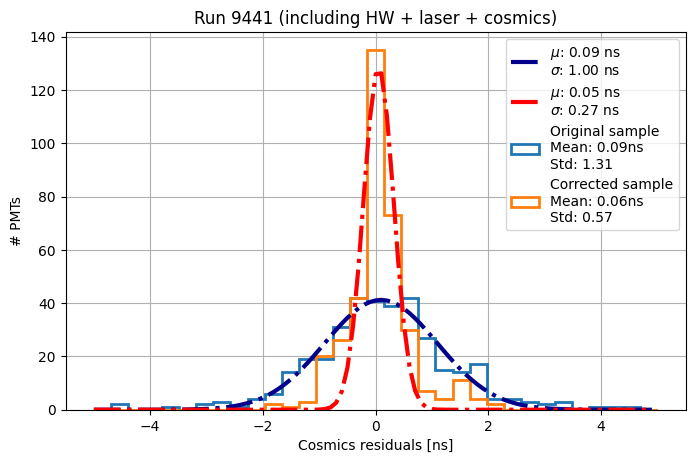

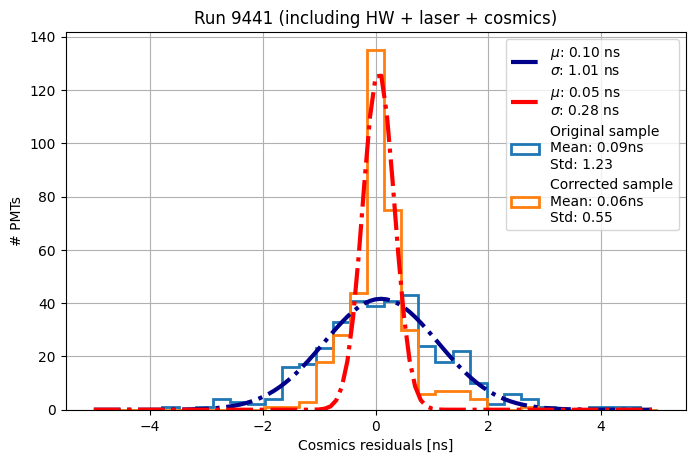

In [27]:
plot_fit(9441,df,df_corr)
plot_fit(9441,Ndf,Ndf_corr)
plot_fit(9441,Ndf_alt,Ndf_alt_corr)

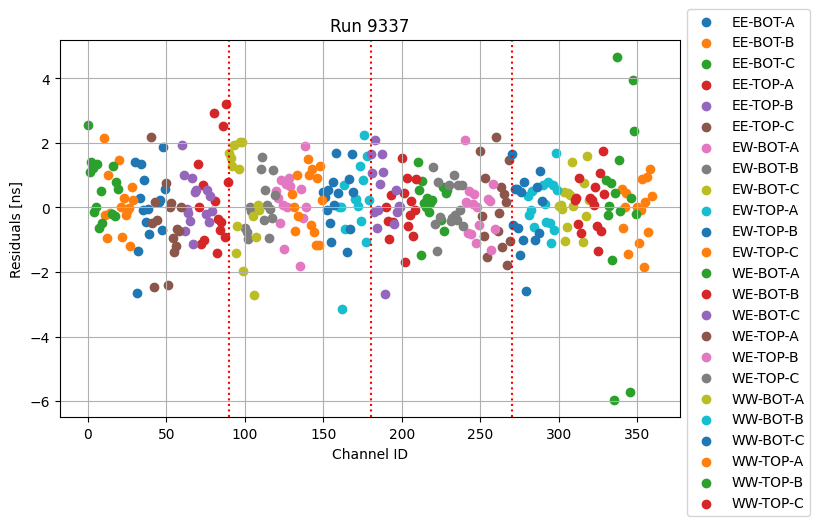

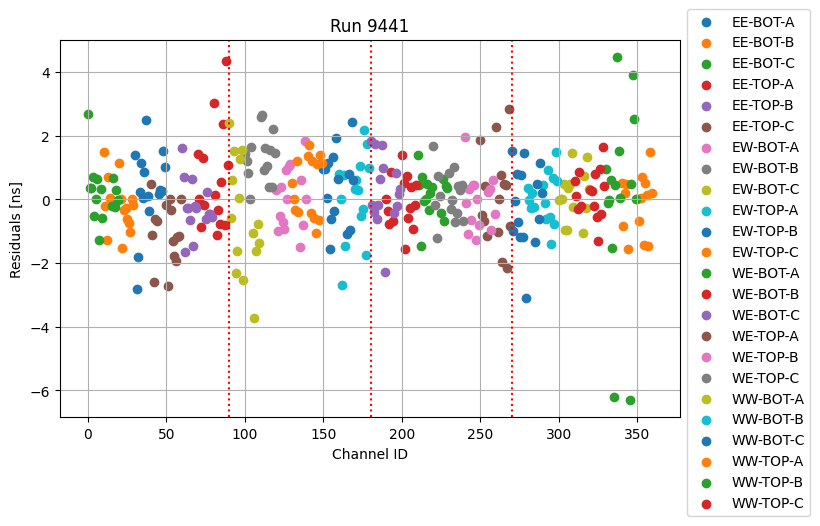

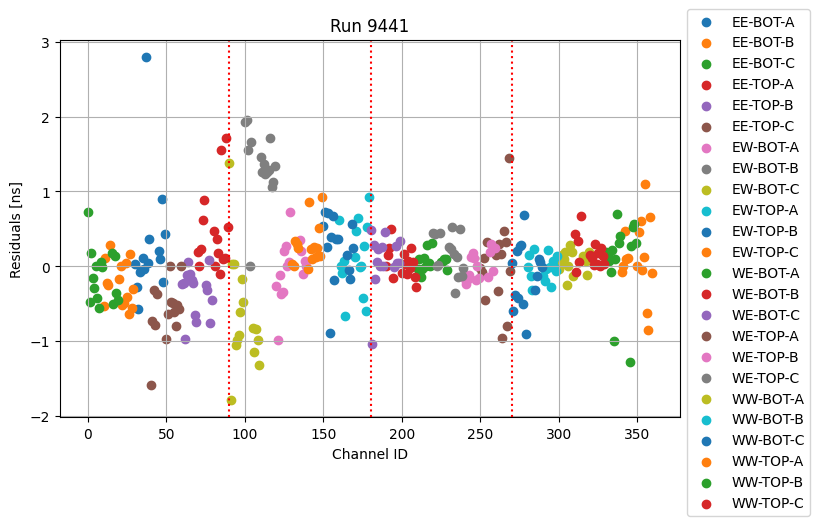

In [28]:
show_status_channels(9337,dfalt)
show_status_channels(9441,Ndf_alt)
show_status_channels(9441,Ndf_alt_corr)

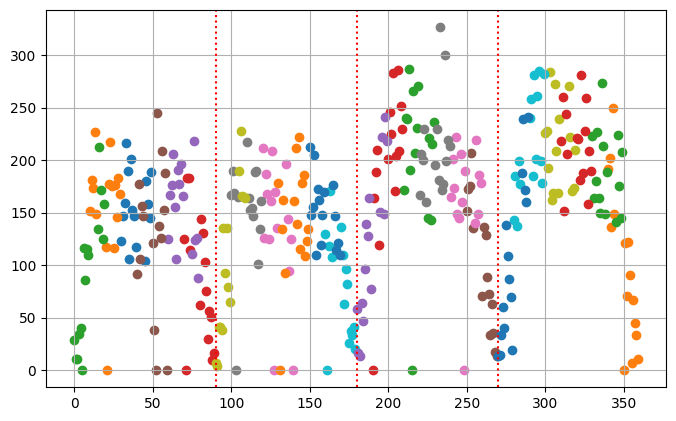

In [29]:
check_stats(9441,path="residuals_test8ns_fixEast_alternative_CORRw9337")

# Periodo 2 - Run 9730

In [30]:
res_9730 = "../output/residuals/Run_2/run9730_residuals_test8ns.csv"
res_9688 = "../output/residuals/Run_2/run9688_residuals_test8ns.csv"
res_9764 = "../output/residuals/Run_2/run9764_residuals_test8ns.csv"

Nres_9730 = "../output/residuals/Run_2/run9730_residuals_test8ns_fixEast_alternative.csv"
Nres_9688 = "../output/residuals/Run_2/run9688_residuals_test8ns_fixEast_alternative.csv"
Nres_9764 = "../output/residuals/Run_2/run9764_residuals_test8ns_fixEast_alternative.csv"

In [31]:
df9730= pd.read_csv(res_9730)
df9688= pd.read_csv(res_9688)
df9764= pd.read_csv(res_9764)
Ndf9730 = pd.read_csv(Nres_9730)
Ndf9688 = pd.read_csv(Nres_9688)
Ndf9764 = pd.read_csv(Nres_9764)

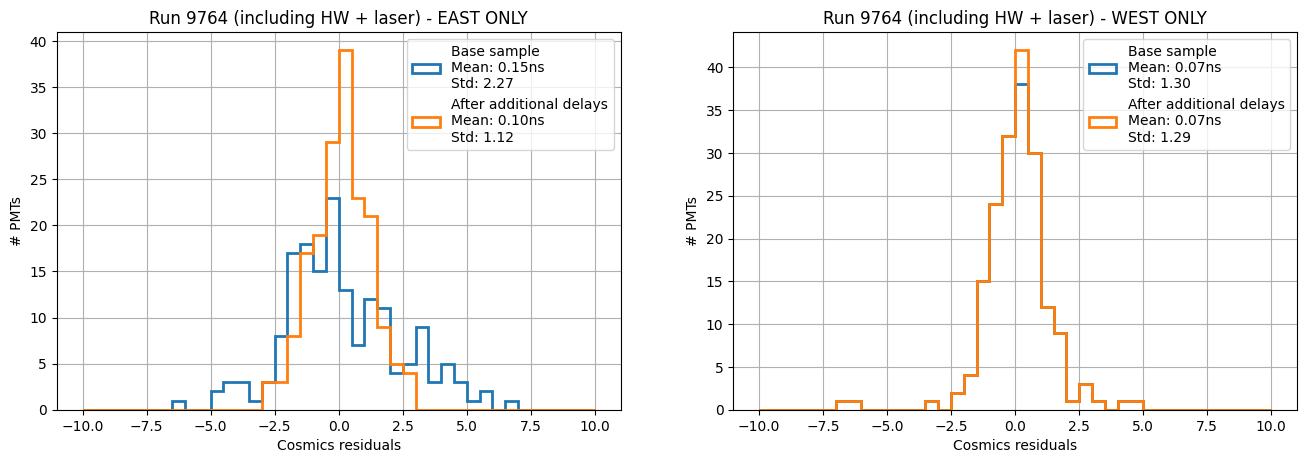

In [32]:
compare_changes_cryowise(9730,df9730,Ndf9730)
compare_changes_cryowise(9688,df9688,Ndf9688)
compare_changes_cryowise(9764,df9764,Ndf9764)

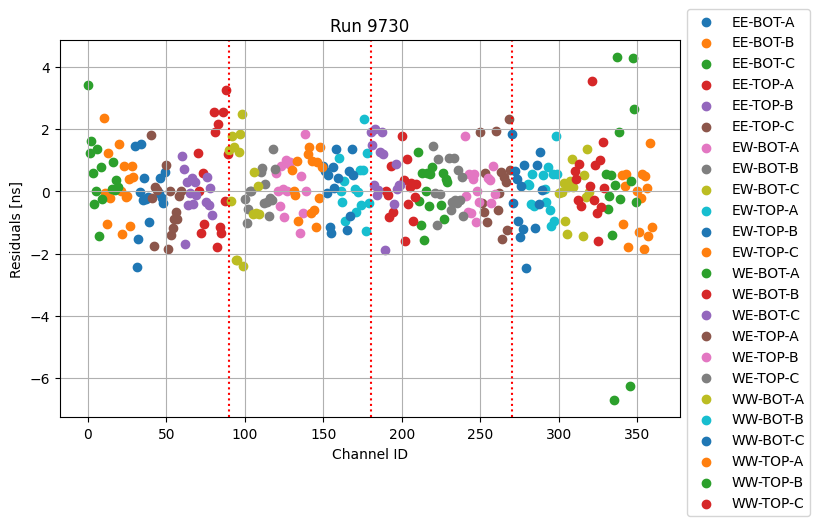

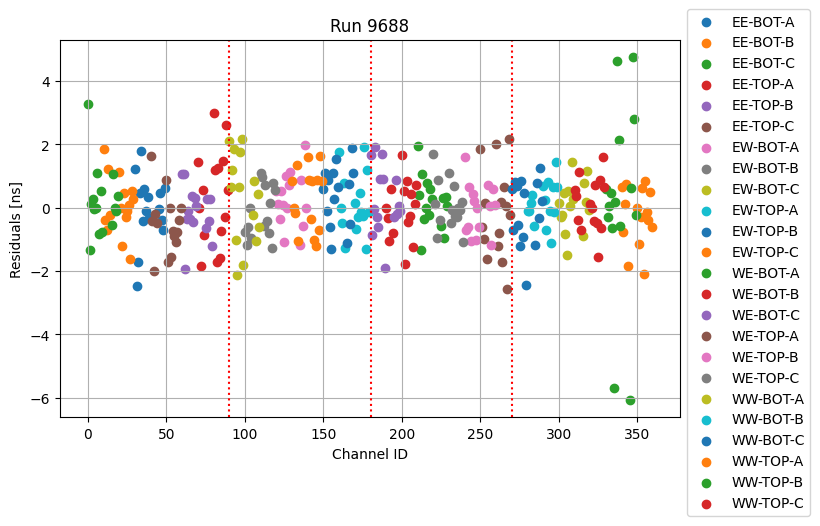

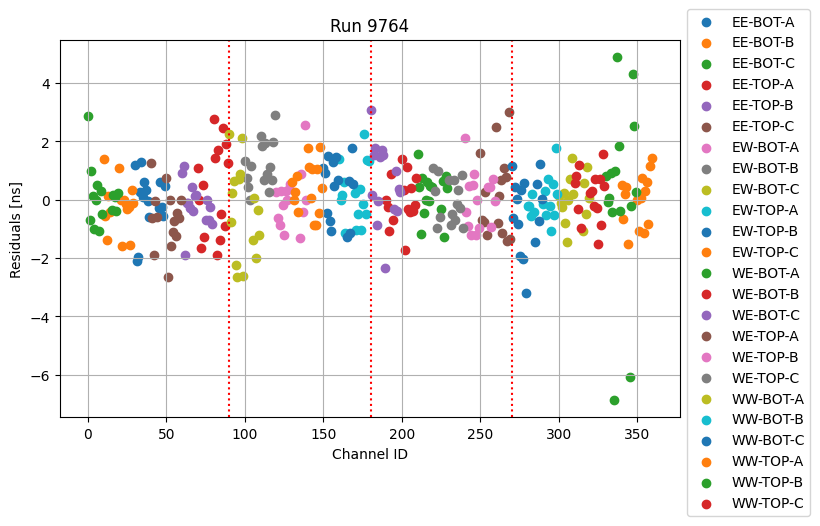

In [33]:
show_status_channels(9730,Ndf9730)
show_status_channels(9688,Ndf9688)
show_status_channels(9764,Ndf9764)

## Validation

In [34]:
Nres_corr_9688 = "../output/residuals/Run_2/run9688_residuals_test8ns_fixEast_alternative_CORRw9730.csv"
Nres_corr_9764 = "../output/residuals/Run_2/run9764_residuals_test8ns_fixEast_alternative_CORRw9730.csv"
Ndfcorr9688 = pd.read_csv(Nres_corr_9688)
Ndfcorr9764 = pd.read_csv(Nres_corr_9764)

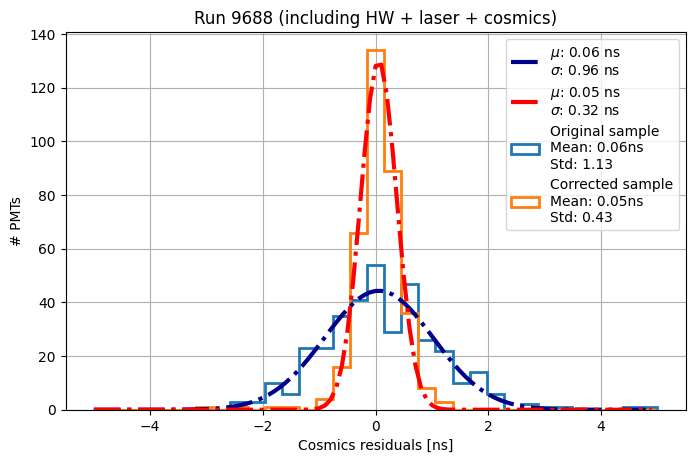

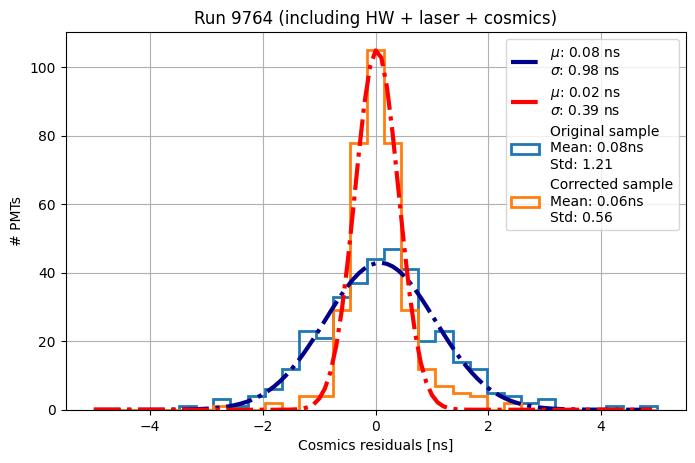

In [35]:
plot_fit(9688,Ndf9688,Ndfcorr9688)
plot_fit(9764,Ndf9764,Ndfcorr9764)

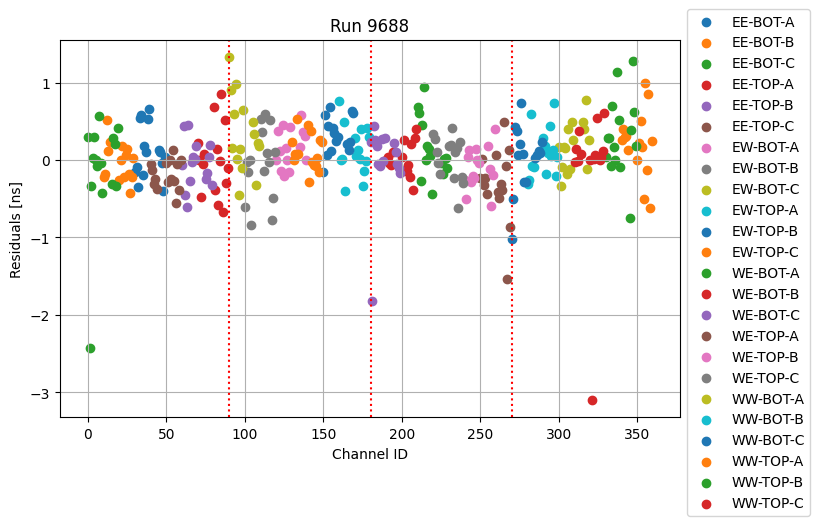

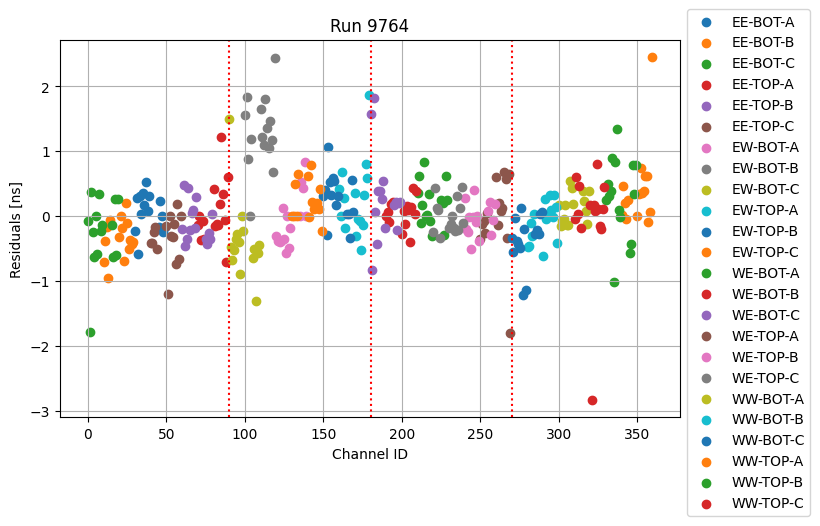

In [36]:
show_status_channels(9688,Ndfcorr9688)
show_status_channels(9764,Ndfcorr9764)

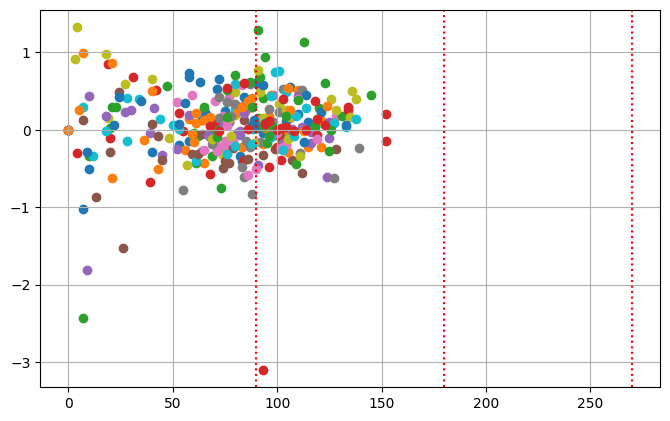

In [37]:
check_stats(9688,path="residuals_test8ns_fixEast_alternative_CORRw9730")
check_stats(9764,path="residuals_test8ns_fixEast_alternative_CORRw9730")

# Period 3 - Run 10085

In [38]:
res_10085 = "../output/residuals/Run_2/run10085_residuals_test8ns.csv"
res_9840 = "../output/residuals/Run_2/run9840_residuals_test8ns.csv"
res_9974 = "../output/residuals/Run_2/run9974_residuals_test8ns.csv"

Nres_10085 = "../output/residuals/Run_2/run10085_residuals_test8ns_fixEast_alternative.csv"
Nres_9840 = "../output/residuals/Run_2/run9840_residuals_test8ns_fixEast_alternative.csv"
Nres_9974 = "../output/residuals/Run_2/run9974_residuals_test8ns_fixEast_alternative.csv"

In [39]:
df10085= pd.read_csv(res_10085)
df9840= pd.read_csv(res_9840)
df9974= pd.read_csv(res_9974)
Ndf10085 = pd.read_csv(Nres_10085)
Ndf9840 = pd.read_csv(Nres_9840)
Ndf9974 = pd.read_csv(Nres_9974)

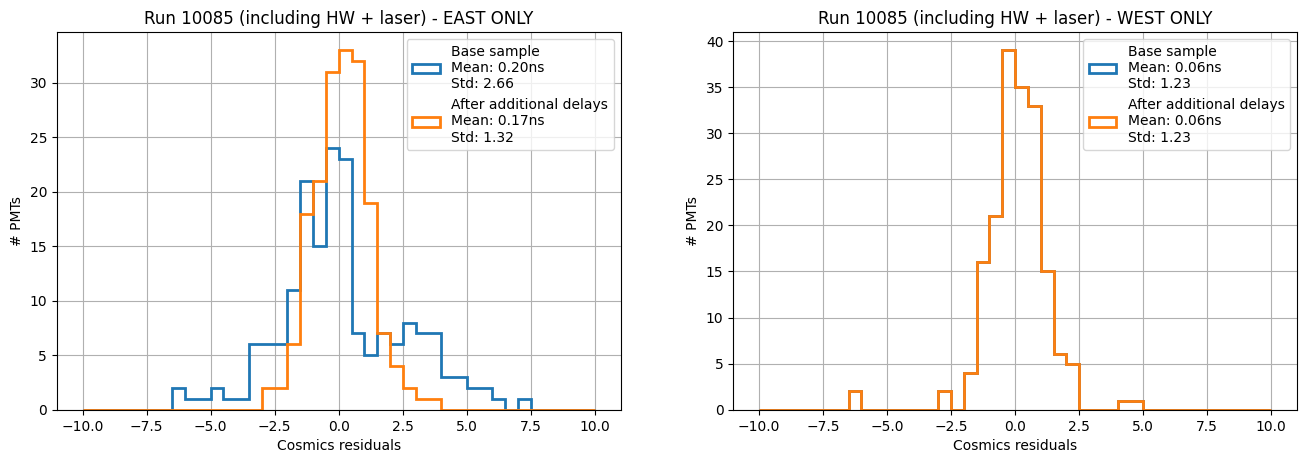

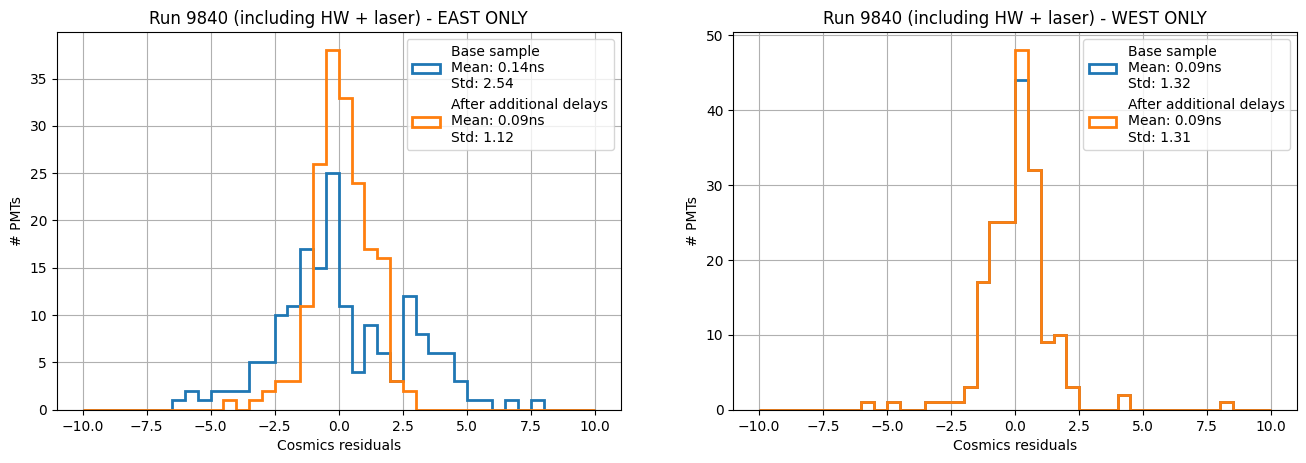

In [40]:
compare_changes_cryowise(10085,df10085,Ndf10085)
compare_changes_cryowise(9840,df9840,Ndf9840)
compare_changes_cryowise(9974,df9974,Ndf9974)

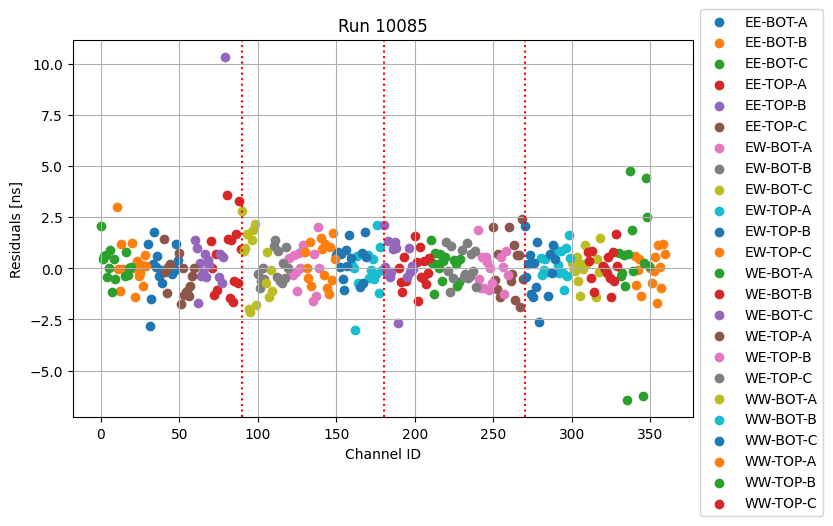

In [41]:
show_status_channels(10085,Ndf10085)
show_status_channels(9840,Ndf9840)
show_status_channels(9974,Ndf9974)

## Validation

In [42]:
Nres_corr_9840 = "../output/residuals/Run_2/run9840_residuals_test8ns_fixEast_alternative_CORRw10085.csv"
Nres_corr_9974 = "../output/residuals/Run_2/run9974_residuals_test8ns_fixEast_alternative_CORRw10085.csv"
Ndfcorr9840 = pd.read_csv(Nres_corr_9840)
Ndfcorr9974 = pd.read_csv(Nres_corr_9974)

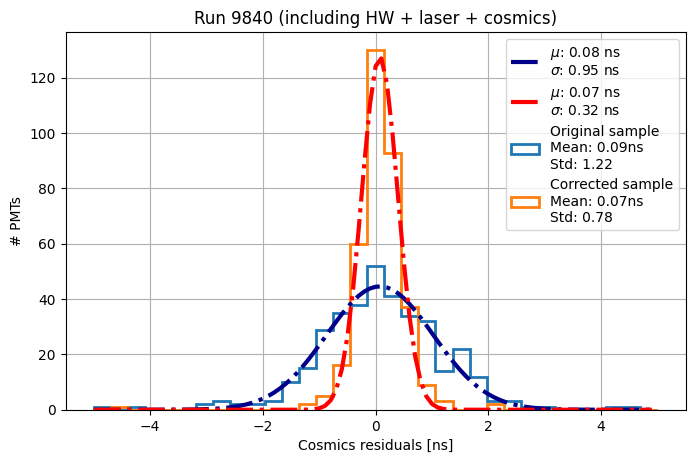

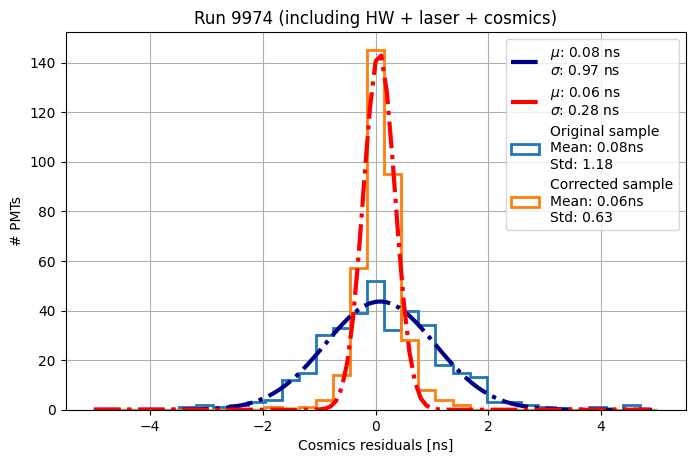

In [43]:
plot_fit(9840,Ndf9840,Ndfcorr9840)
plot_fit(9974,Ndf9974,Ndfcorr9974)

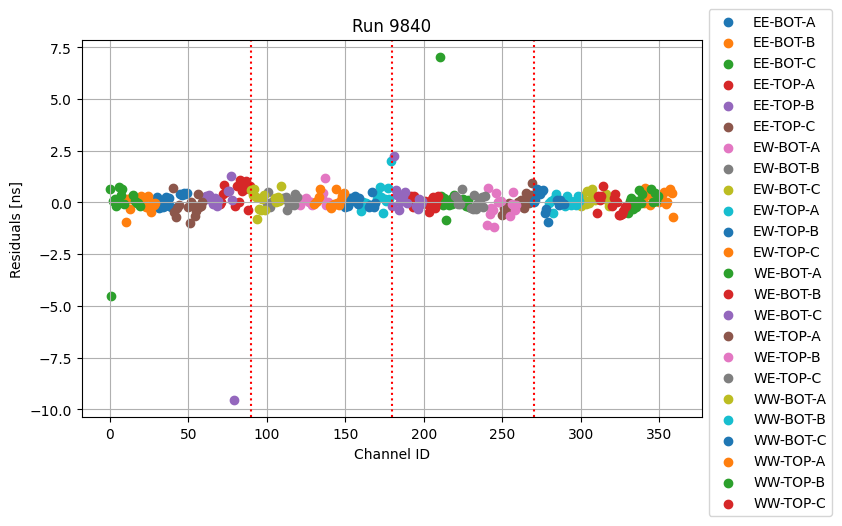

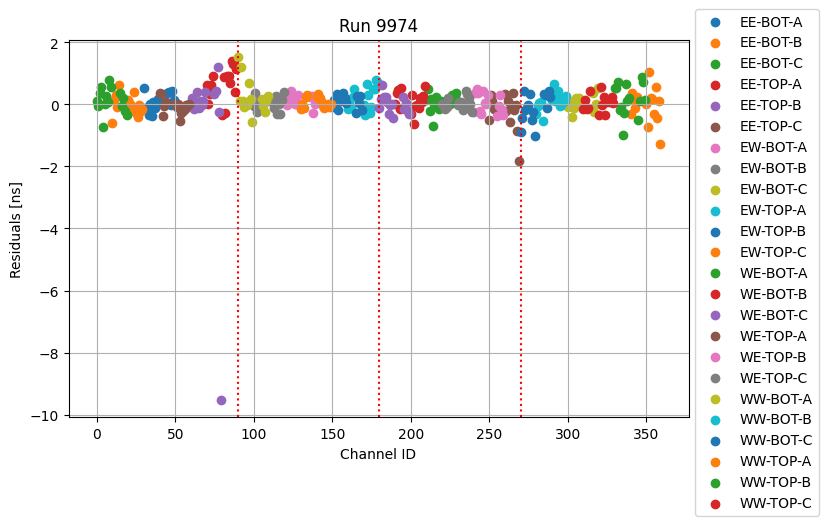

In [44]:
show_status_channels(9840,Ndfcorr9840)
show_status_channels(9974,Ndfcorr9974)

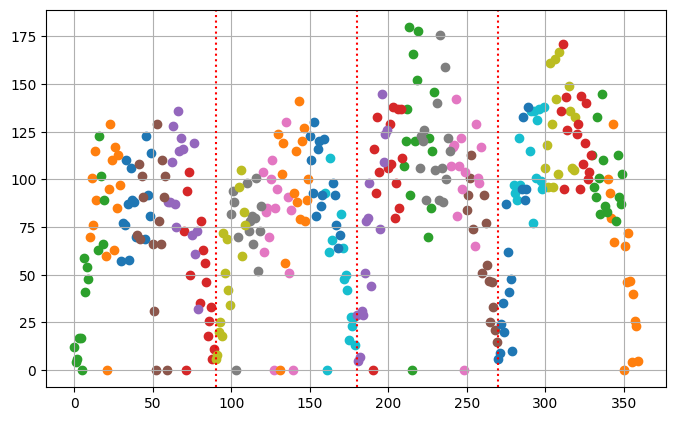

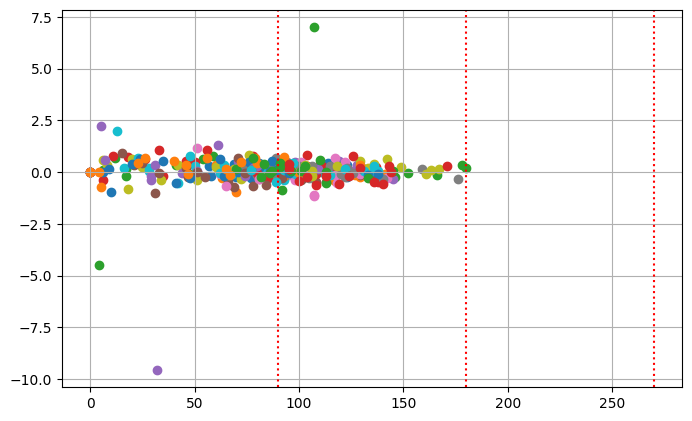

In [45]:
check_stats(9840,path="residuals_test8ns_fixEast_alternative_CORRw10085")
check_stats(9974,path="residuals_test8ns_fixEast_alternative_CORRw10085")

# TEST 2

Reducing to -4ns

In [46]:
def do_everything(run, corr):
    t = "../output/residuals/Run_2/run{}_residuals_test2.csv".format(run)
    c = "../output/residuals/Run_2/run{}_residuals_test2_CORRw{}.csv".format(run,corr)

    dt = pd.read_csv(t)
    dc = pd.read_csv(c)
    show_status_channels(run,dc)
    plot_fit(run,dt,dc)

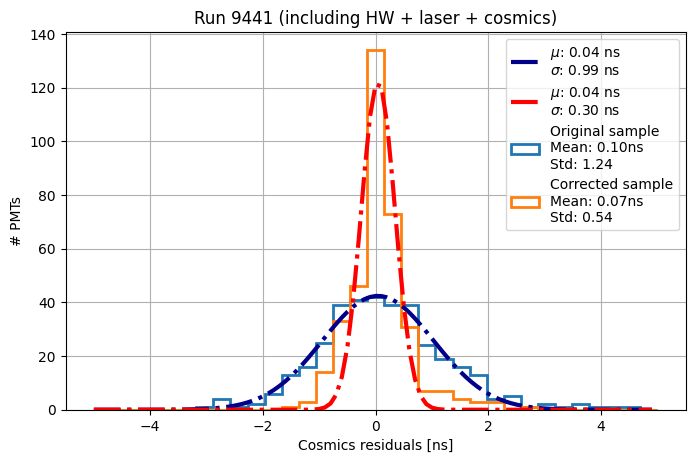

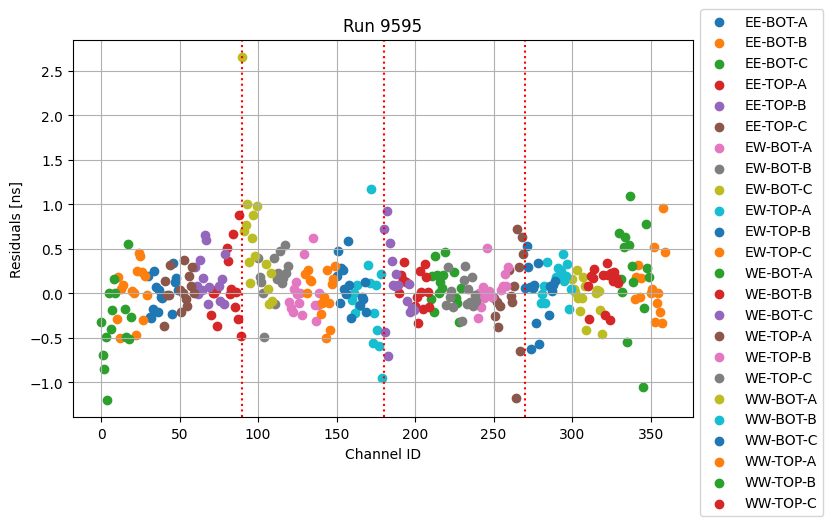

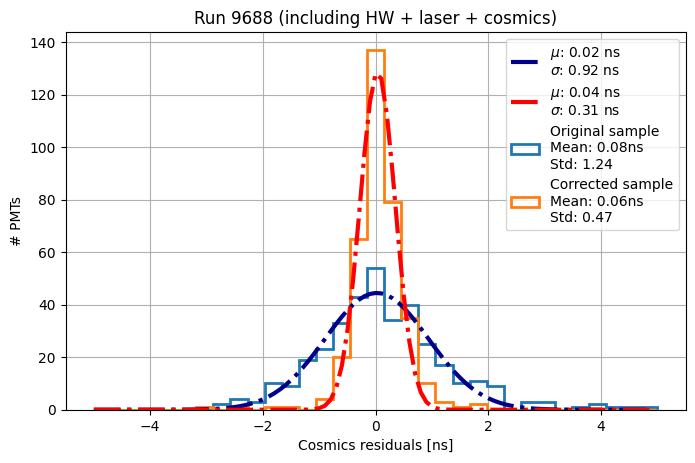

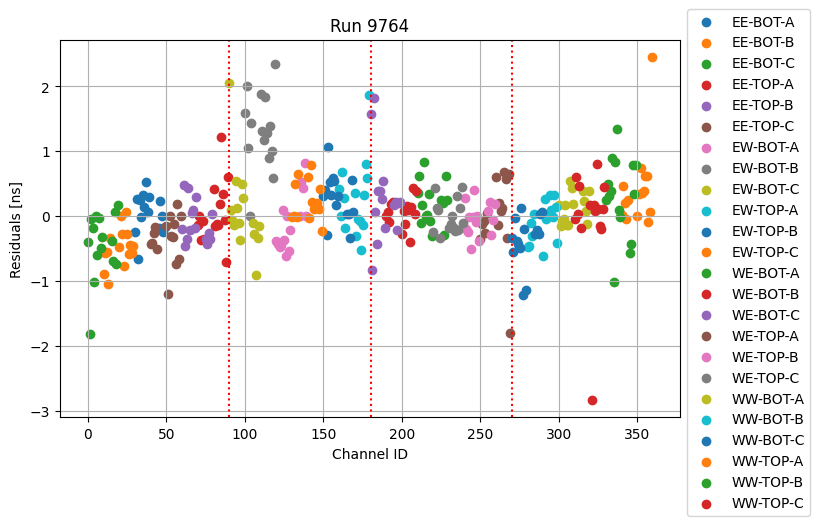

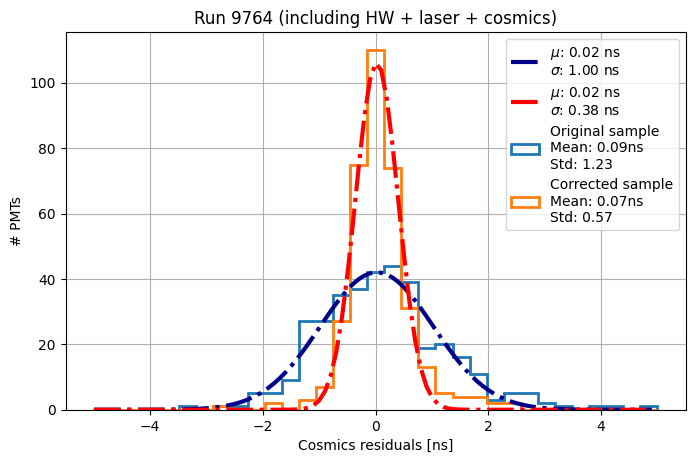

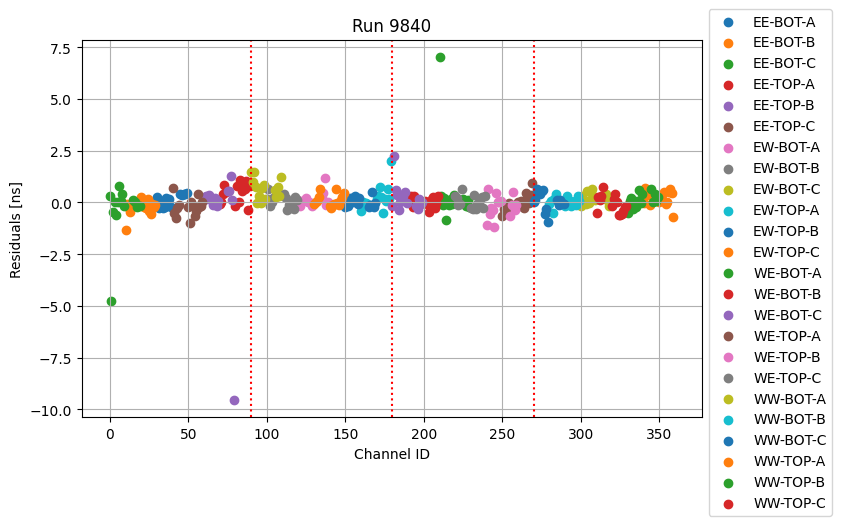

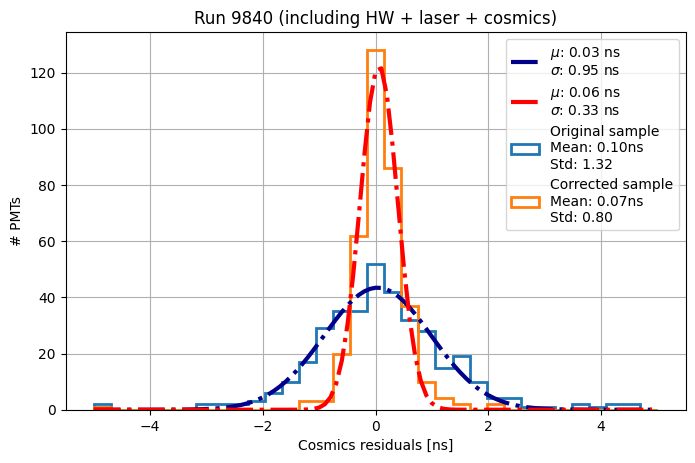

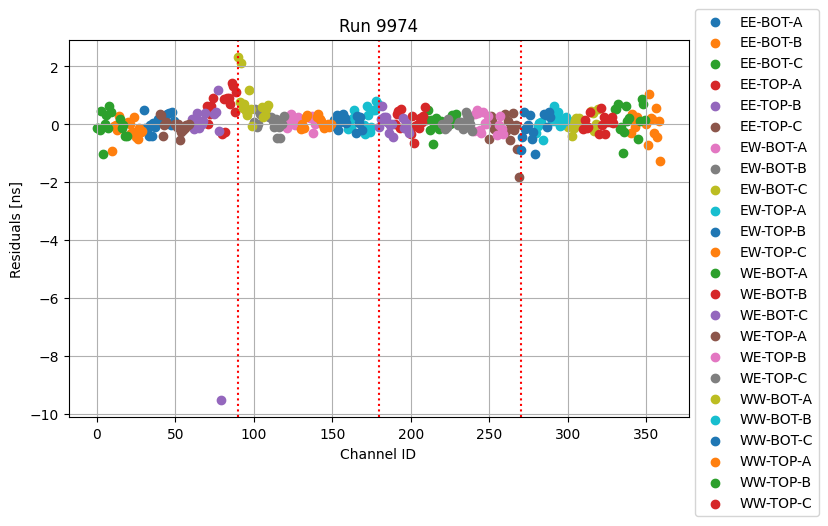

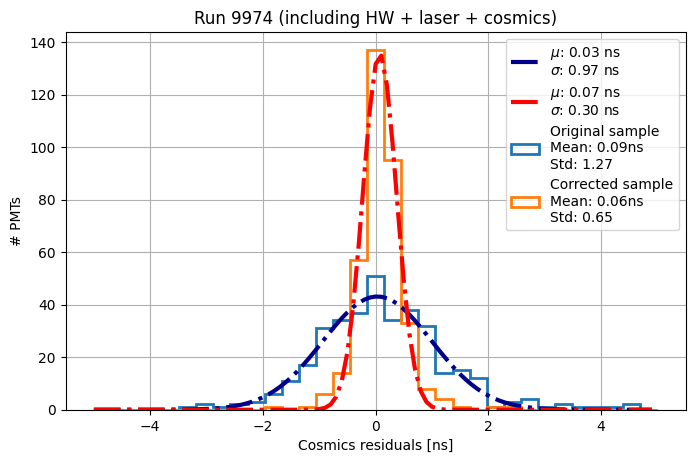

In [47]:
#do_everything(9337)
do_everything(9441,9337)
do_everything(9595,9337)
do_everything(9688,9730)
#do_everything(9730)
do_everything(9764,9730)
do_everything(9840,10085)
do_everything(9974,10085)
#do_everything(10085)

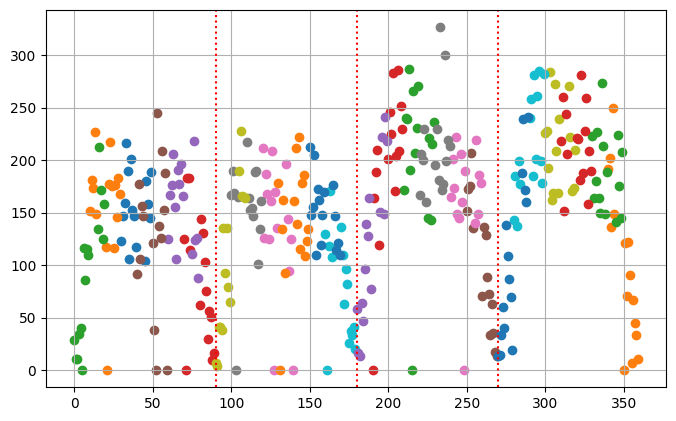

In [48]:
check_stats(9441)

# TEST WITH CORRECTIONS FROM RAW
Using flashana in a modified area in which phase delay corrections are added to the hits before flash creation. Track file is still the same (hoping track/flash matching has not changed).
This is basically the same checks as putting the corrections in the database

In [56]:
def run_checks(run, corr=0):
    res = "../output/residuals/Run_2/run{}_residuals_test8ns.csv".format(run)
    alt = "../output/residuals/Run_2/run{}_residuals_test8ns_fixEast_alternative.csv".format(run)
    flash = "../output/residuals/Run_2/run{}_residuals_testStandard_flashana.csv".format(run)
    df = pd.read_csv(res)
    adf = pd.read_csv(alt)
    fdf = pd.read_csv(flash)
    validate_corrections(run,df,fdf)
    compare_changes_cryowise(run,df,fdf)
    show_status_channels(run,df)
    show_status_channels(run,adf)
    show_status_channels(run,fdf)
    
    if corr != 0:
        cflash = "../output/residuals/Run_2/run{}_residuals_testStandard_flashana_CORRw{}.csv".format(run,corr)
        dc = pd.read_csv(cflash)
        plot_fit(run,fdf,dc)

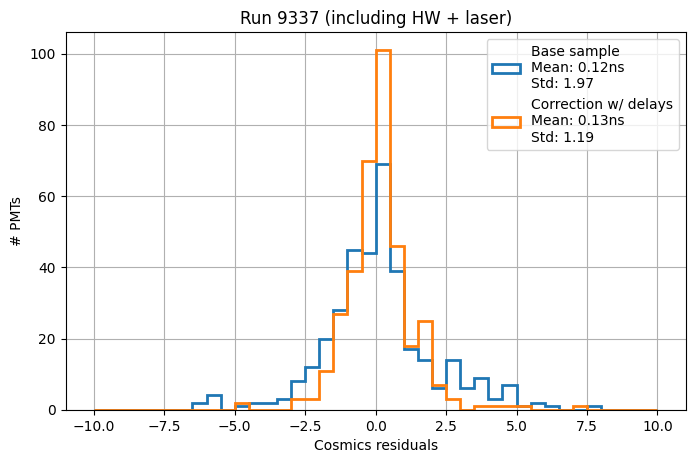

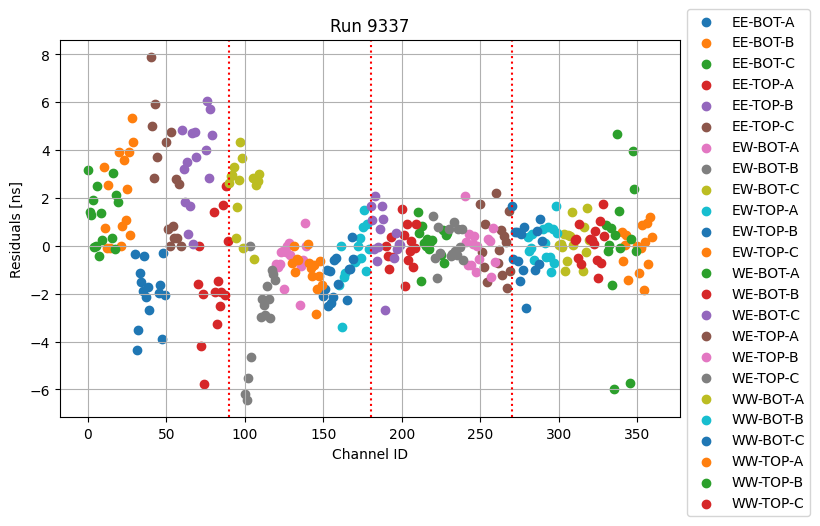

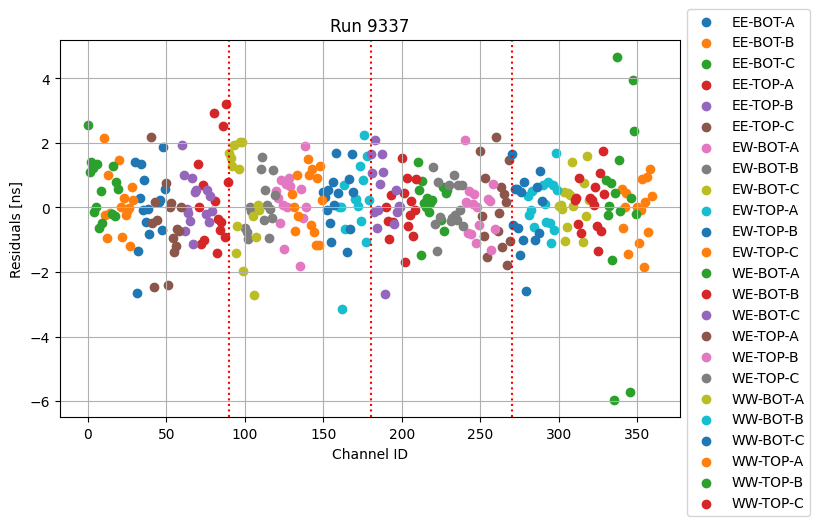

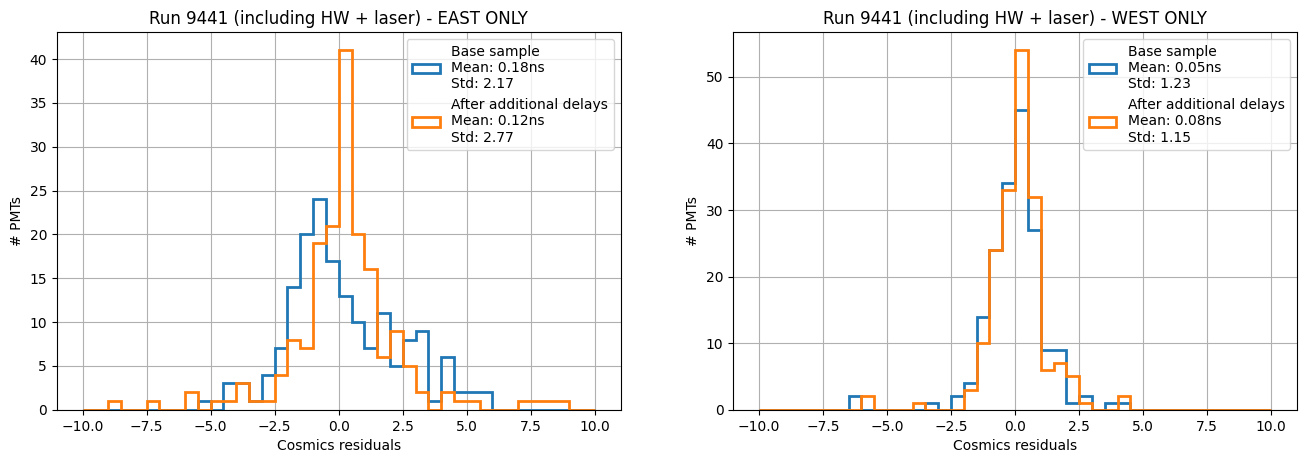

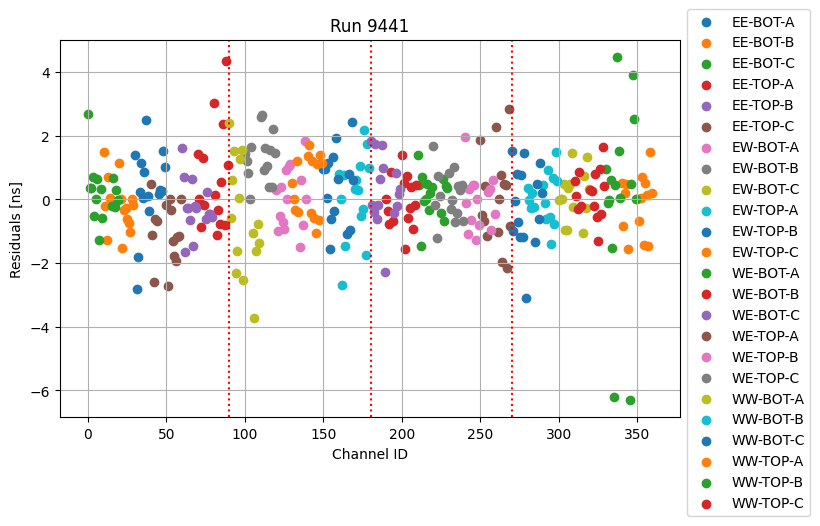

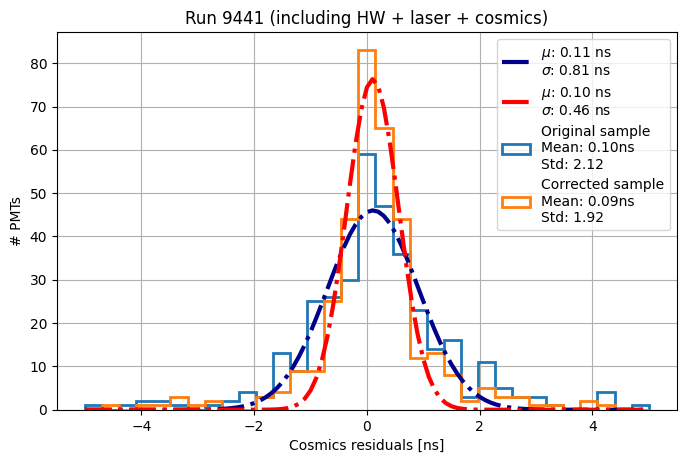

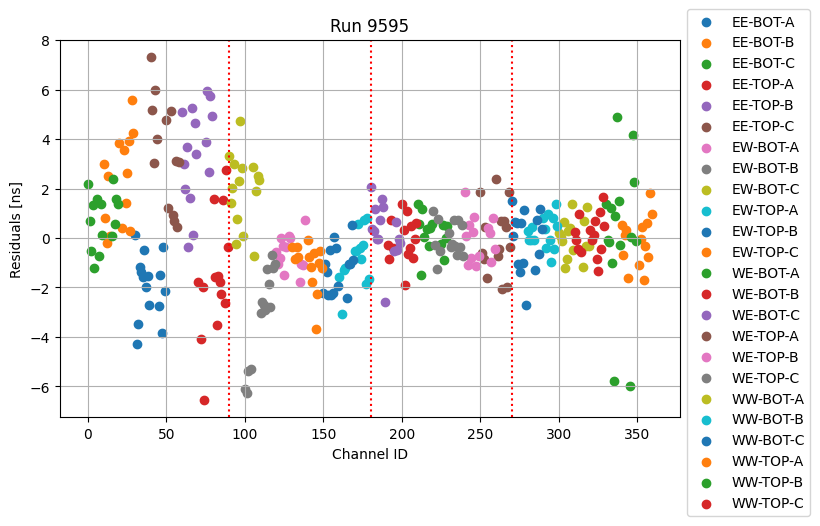

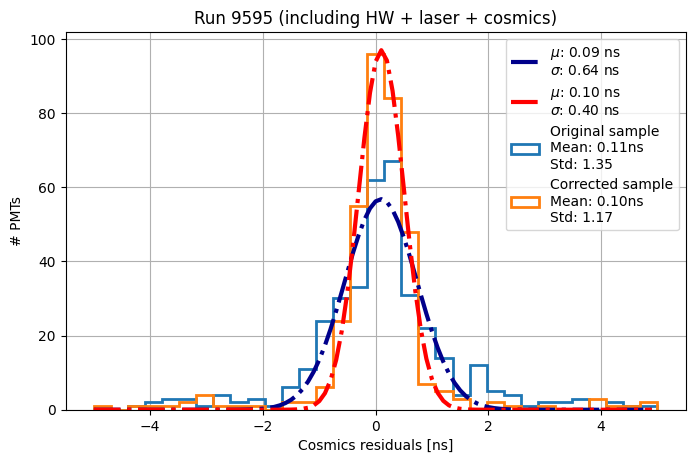

In [58]:
run_checks(9337)
run_checks(9441, 9337)
run_checks(9595, 9337)

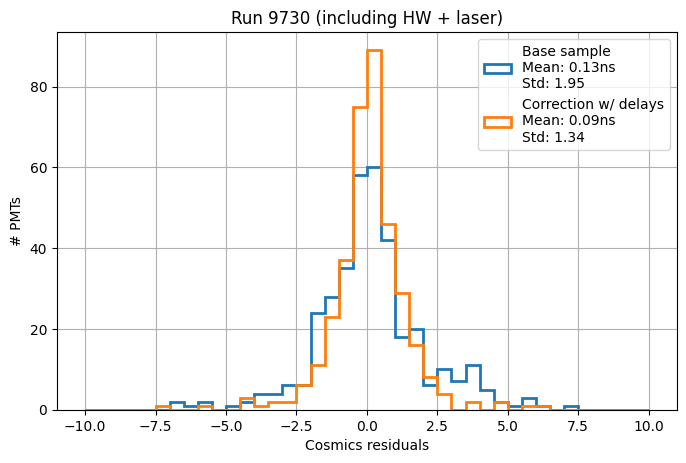

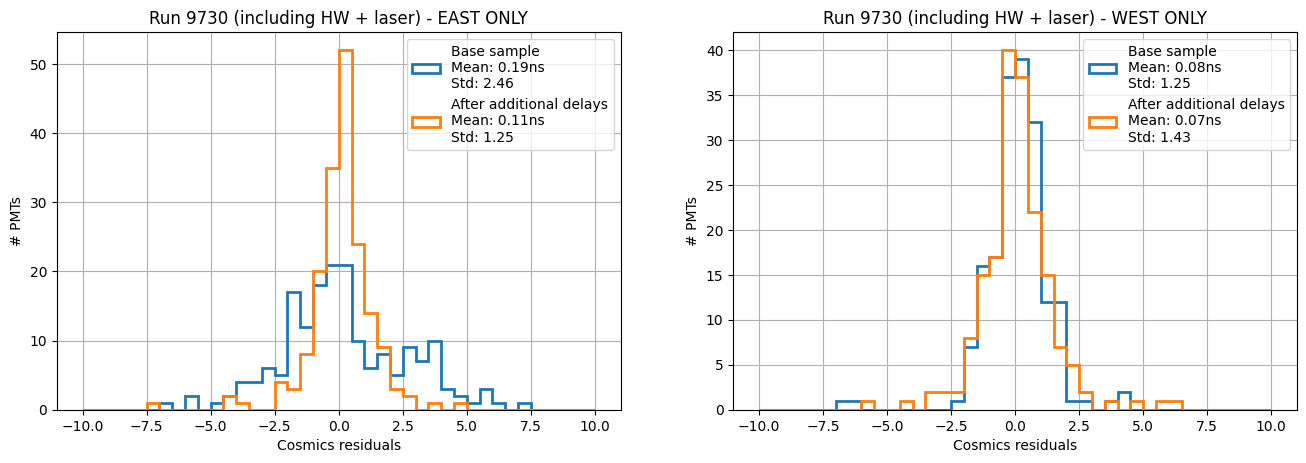

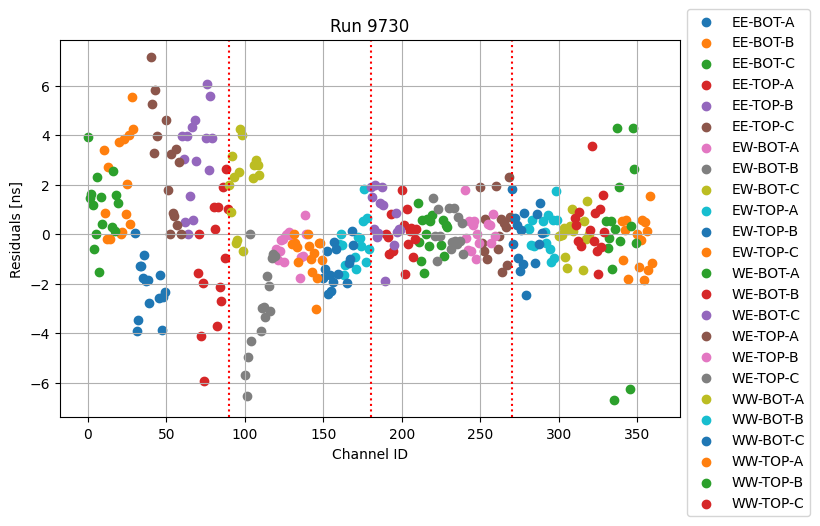

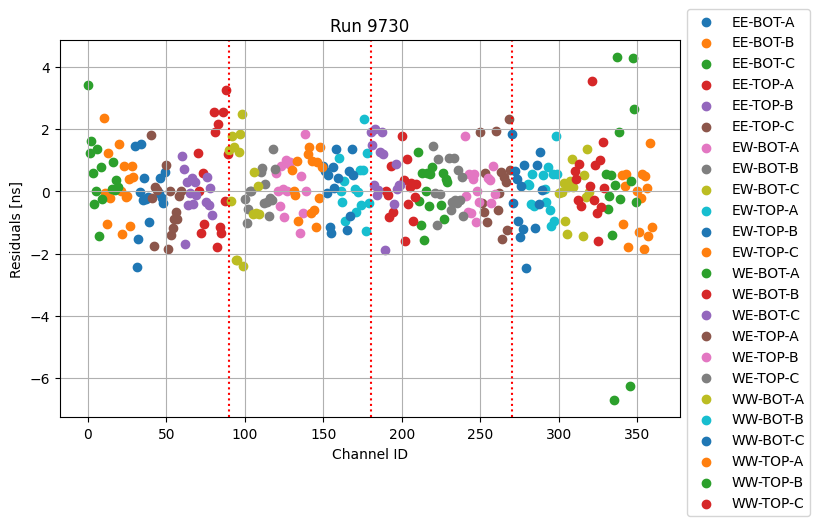

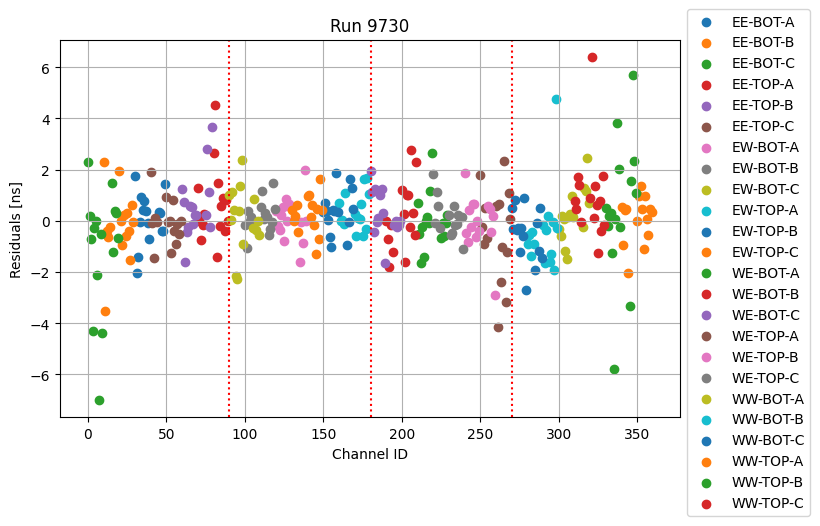

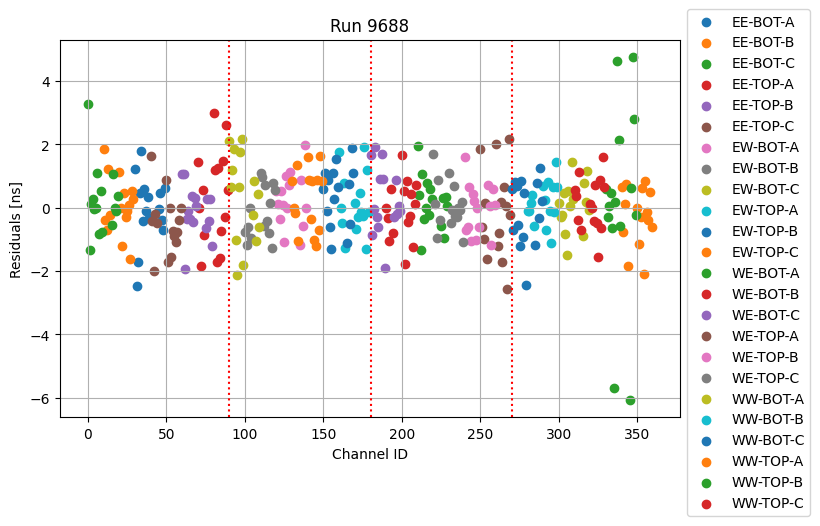

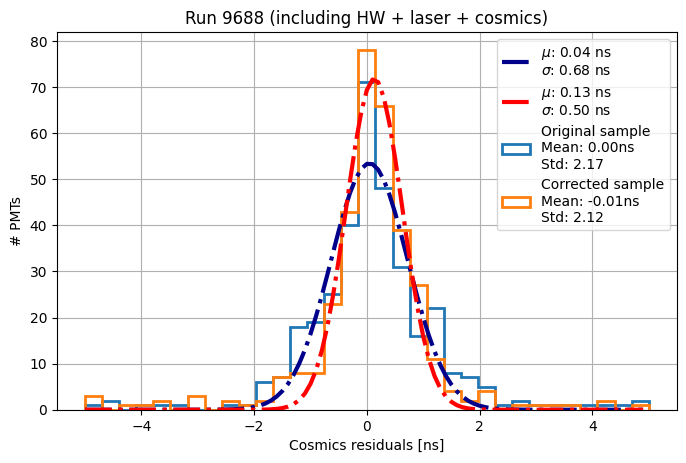

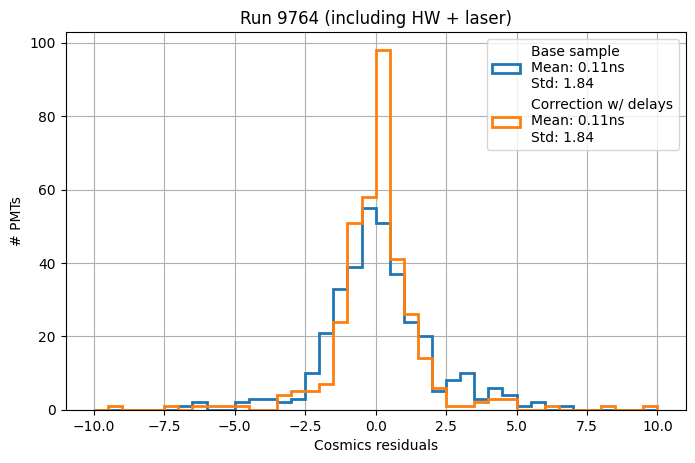

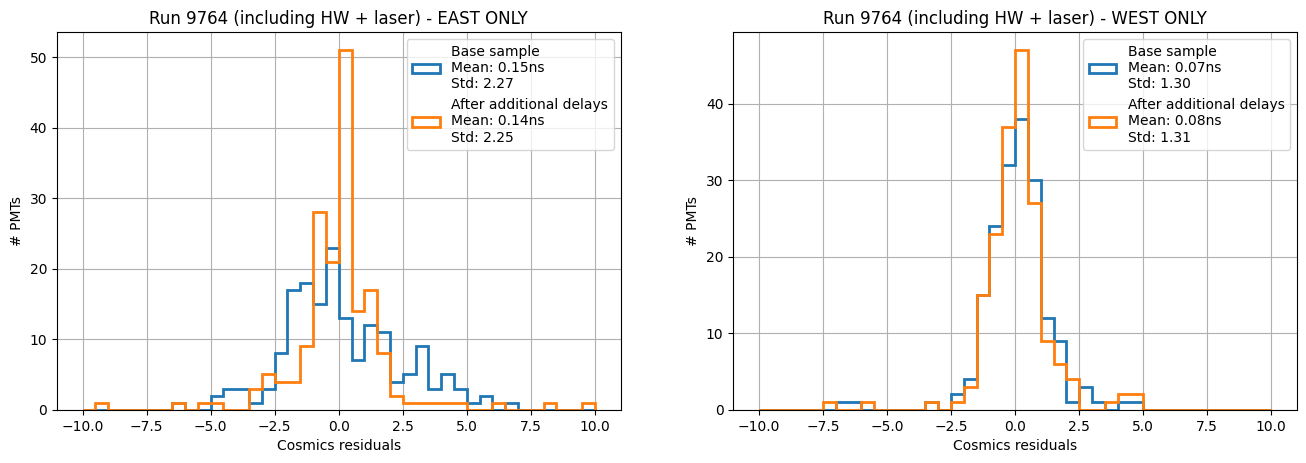

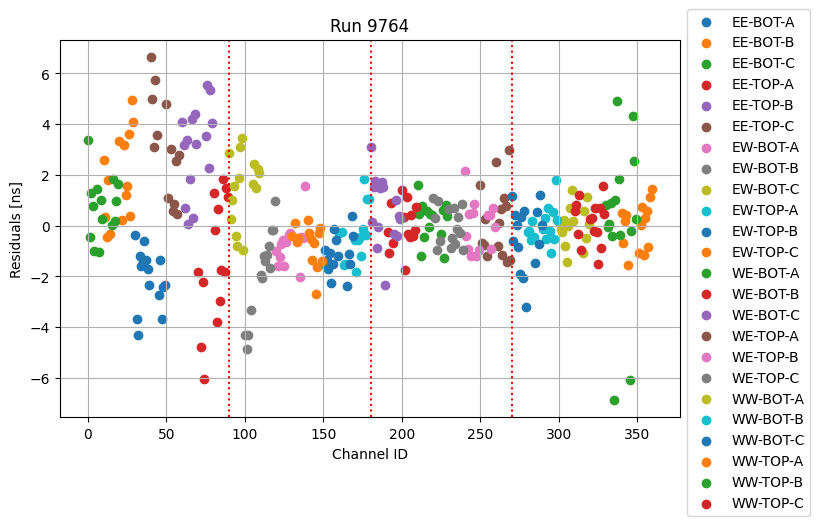

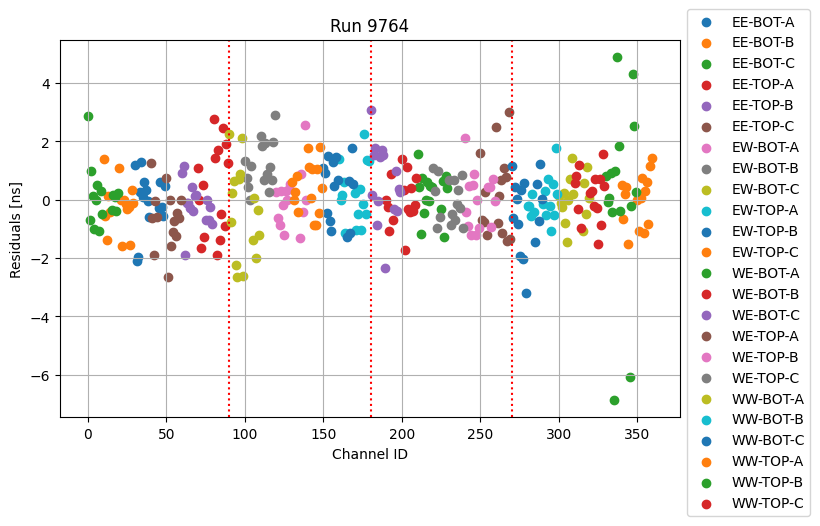

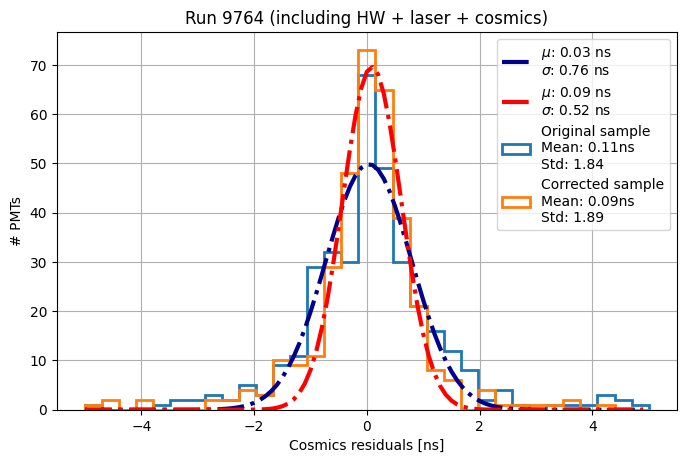

In [59]:
run_checks(9730)
run_checks(9688, 9730)
run_checks(9764, 9730)